In [1]:
import pandas as pd
import numpy as np
pasc_df=pd.read_csv("pasc_df_2026.csv")#,index=False)

npz_file_path = "three_cohorts2026.npz"
with np.load(npz_file_path,allow_pickle=True) as data:
    # Access the arrays by their names
    protected_ids = data['arr1']
    responder_ids = data['arr2']
    refractory_ids = data['arr3']

In [2]:
np.unique(pasc_df['index'])
pasc_df.head()

,id,index,date,name,prior_vax_count
0,RA11305,pasc,2021-01-01,16.0,3
1,RA11305,pasc,2021-04-03,14.0,3
2,RA11305,pasc,2021-06-28,8.0,3
3,RA11305,pasc,2021-09-28,13.0,3
4,RA11305,pasc,2021-12-23,10.0,4


In [36]:
# np.unique(pasc_df['name'])
# pasc_df['name']
import pandas as pd
import pandas as pd
import numpy as np

# df_sorted = pasc_df[pasc_df['id'].isin(protected_ids)].sort_values(by=['id', 'date'], ascending=[True, True])
# df_sorted = pasc_df[pasc_df['id'].isin(responder_ids)].sort_values(by=['id', 'date'], ascending=[True, True])
df_sorted = pasc_df[pasc_df['id'].isin(refractory_ids)].sort_values(by=['id', 'date'], ascending=[True, True])

# 2. Group by ID and take the first row (the earliest occurrence)
earliest_pasc = df_sorted.groupby('id').first().reset_index()

# 3. Now compute statistics on the 'prior_vax_count' column of these earliest records
vax_stats_at_start = earliest_pasc['prior_vax_count'].value_counts(dropna=False).sort_index()

# 4. Calculate Mean/Median of doses at initial PASC
mean_doses_at_start = earliest_pasc['prior_vax_count'].mean()
median_doses_at_start = earliest_pasc['prior_vax_count'].median()

# Display results
print("Vaccine Dose Distribution at Initial PASC Score:")
print(vax_stats_at_start)
print(f"\nAverage doses at first PASC: {mean_doses_at_start:.2f}")


Vaccine Dose Distribution at Initial PASC Score:
prior_vax_count
0      7
1     39
2    154
3    355
4    110
Name: count, dtype: int64

Average doses at first PASC: 2.78


In [17]:
import pandas as pd

def build_group_plot_df(pasc_df, ids, group_name):
    df_sorted = pasc_df[pasc_df["id"].isin(ids)].sort_values(["id", "date"])
    earliest = df_sorted.groupby("id", as_index=False).first()

    s = earliest["prior_vax_count"].value_counts(dropna=False).sort_index()

    out = s.rename_axis("prior_vax_count").reset_index(name="count")
    out["group_name"] = group_name
    return out

plot_df = pd.concat([
    build_group_plot_df(pasc_df, protected_ids,  "Protected"),
    build_group_plot_df(pasc_df, responder_ids,  "Responder"),
    build_group_plot_df(pasc_df, refractory_ids, "Refractory"),
], ignore_index=True)

# optional: ensure consistent y-axis categories across groups (fill missing dose bins with 0)
all_doses = sorted(plot_df["prior_vax_count"].dropna().unique())
all_groups = plot_df["group_name"].unique()

idx = pd.MultiIndex.from_product([all_doses, all_groups], names=["prior_vax_count", "group_name"])
plot_df = (
    plot_df.set_index(["prior_vax_count", "group_name"])
           .reindex(idx, fill_value=0)
           .reset_index()
)
# sns.barplot(data=plot_df, y="prior_vax_count", x="count", hue="group_name", orient="h")


In [19]:
print("hello")
plot_df

hello


,prior_vax_count,group_name,count
0,0,Protected,993
1,0,Responder,32
2,0,Refractory,7
3,1,Protected,340
4,1,Responder,151
5,1,Refractory,39
6,2,Protected,1421
7,2,Responder,697
8,2,Refractory,154
9,3,Protected,3988


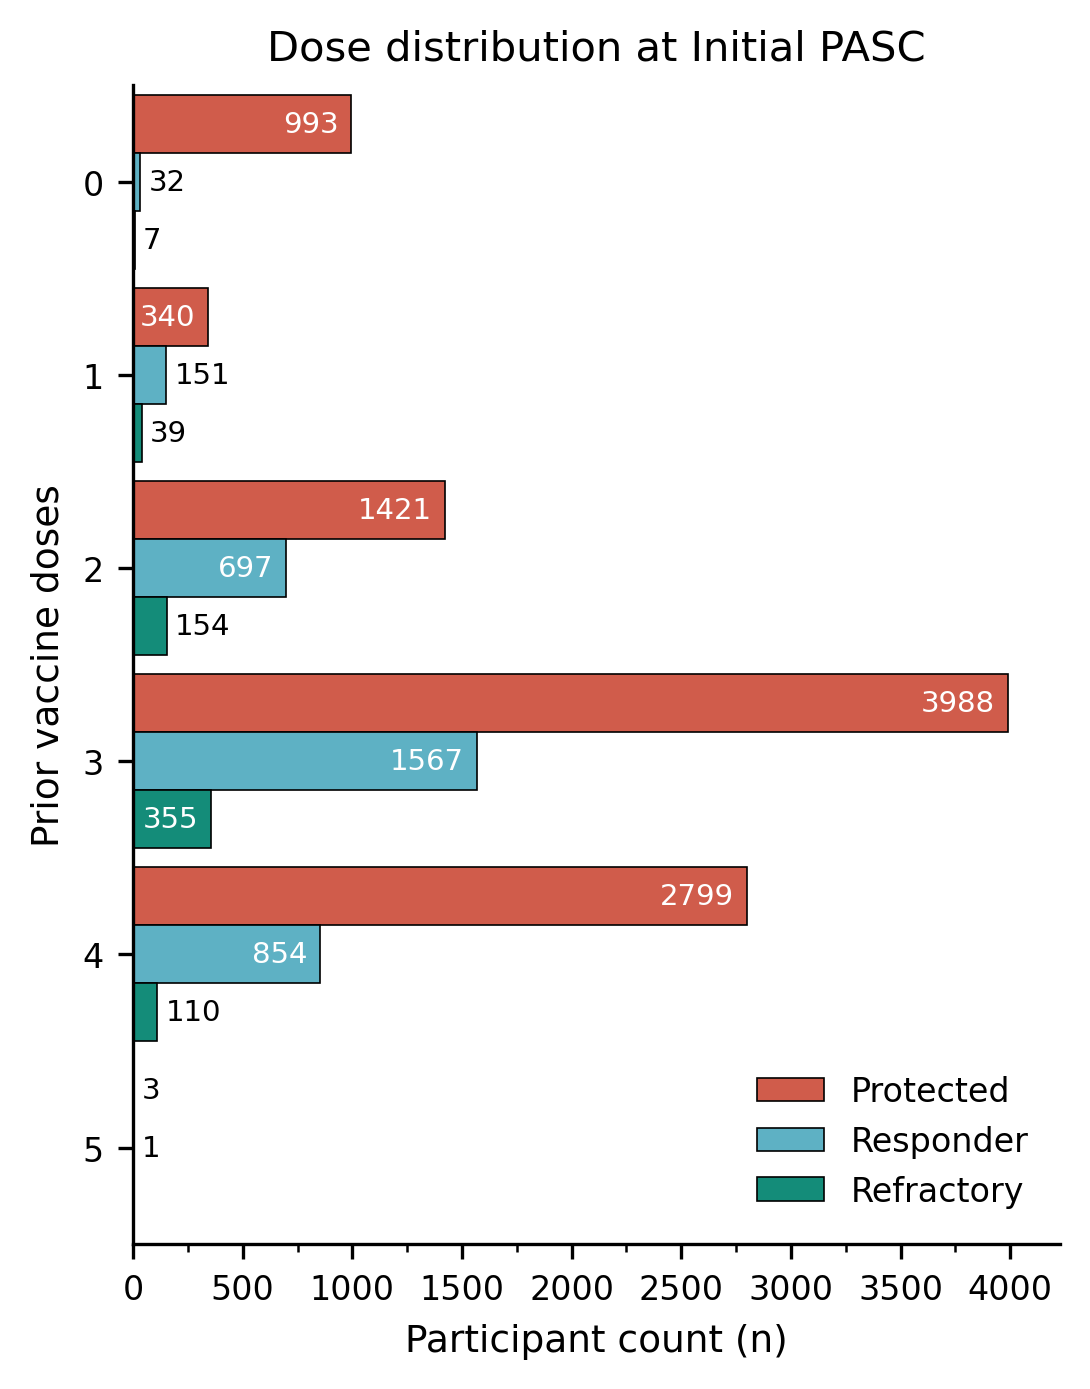

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

# --- Nature-ish defaults (compact, consistent) ---
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8
})

colors = ['#E64B35FF', '#4DBBD5FF', '#00A087FF']  # your NPG palette

# 1) Make the figure less tall (main fix for “too sparse”)
fig, ax = plt.subplots(figsize=(3.6, 4.6), dpi=300)

sns.barplot(
    data=plot_df,
    y="prior_vax_count",
    x="count",
    hue="group_name",
    palette=colors,
    orient="h",
    dodge=True,
    width=0.90,          # thicker bars
    edgecolor="black",
    linewidth=0.4,       # lighter outline than 0.6
    ax=ax
)

# 2) Titles/labels: Nature tends to keep these modest (often no title; caption does the work)
ax.set_title("Dose distribution at Initial PASC", fontsize=10, pad=6)
ax.set_xlabel("Participant count (n)", fontsize=9)
ax.set_ylabel("Prior vaccine doses", fontsize=9)

# 3) Ticks: outward, with minor ticks; no grid
ax.tick_params(direction="out", length=3.5, width=0.8, labelsize=8)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.tick_params(axis="x", which="minor", direction="out", length=2, width=0.6)

# 4) Limits: give only a *little* extra room for labels
max_val = plot_df["count"].max()
ax.set_xlim(0, max_val * 1.06)

# 5) Legend: inside the plot area (bottom-right is fine here)
leg = ax.legend(title=None, frameon=False, fontsize=8, loc="lower right",
                bbox_to_anchor=(0.98, 0.02), borderaxespad=0.0)

# 6) Data labels: inside for large bars, outside for small bars (reduces clutter near x~0)
threshold = max_val * 0.08  # tune 0.05–0.12 depending on your data
for p in ax.patches:
    w = p.get_width()
    if w <= 0:
        continue
    y = p.get_y() + p.get_height() / 2

    if w >= threshold:
        # label inside the bar, near the end
        ax.annotate(f"{int(w)}", (w, y),
                    xytext=(-3, 0), textcoords="offset points",
                    ha="right", va="center", fontsize=7, color="white", clip_on=True)
    else:
        # label outside with small offset
        ax.annotate(f"{int(w)}", (w, y),
                    xytext=(2, 0), textcoords="offset points",
                    ha="left", va="center", fontsize=7, color="black", clip_on=True)

sns.despine(ax=ax)
fig.tight_layout(pad=0.6)
fig.savefig("Dose_Distribution_Nature_compact.pdf", bbox_inches="tight")
plt.show()


In [8]:
import time
start_time = time.time()
dose_response1 = pasc_df[pasc_df['id'].isin(protected_ids)].groupby('prior_vax_count')['name'].agg(['mean', 'std', 'count'])
dose_response1['dose'] = dose_response1.index
dose_response1['group'] = 'Protected'
end_time = time.time()
print(end_time - start_time)
# print("Dose-Response Trend for protected:")
# print(dose_response)

start_time = time.time()
dose_response2 = pasc_df[pasc_df['id'].isin(responder_ids)].groupby('prior_vax_count')['name'].agg(['mean', 'std', 'count'])
dose_response2['dose'] = dose_response2.index
dose_response2['group'] = 'Responder'
end_time = time.time()
print(end_time - start_time)
# print("Dose-Response Trend for protected:")
# print(dose_response)

start_time = time.time()
dose_response3 = pasc_df[pasc_df['id'].isin(refractory_ids)].groupby('prior_vax_count')['name'].agg(['mean', 'std', 'count'])
dose_response3['dose'] = dose_response3.index
dose_response3['group'] = 'Refractory'
end_time = time.time()
print(end_time - start_time)
# print("Dose-Response Trend for refractory:")
# print(dose_response)

df = pd.concat([dose_response1, dose_response2, dose_response3], ignore_index=True)
# -------------------------
# Helper: compute % improvement vs peak (positive = better)
# and 95% CI band (from SEM)
# -------------------------
def add_improvement(df, peak_dose):
    d = df.copy()
    peak_mean = float(d.loc[d['dose']==peak_dose, "mean"].iloc[0])
    # % improvement = reduction from peak
    d["improve_pct"] = (peak_mean - d["mean"]) / peak_mean * 100.0

    sem = d["std"] / np.sqrt(d["count"])
    sem_pct = (sem / peak_mean) * 100.0
    z = 1.96
    d["low"] = d["improve_pct"] - z * sem_pct
    d["high"]= d["improve_pct"] + z * sem_pct
    d["peak_dose"] = peak_dose
    d["peak_mean"] = peak_mean
    return d

# Peak definition:
# - Responder: dose 1 (your narrative)
# - Refractory: dose 1 (post-immunization anchor)
# - Protected: dose 2 (it actually peaks there in your summary)
df2 = pd.concat([
    add_improvement(dose_response1, peak_dose=2),
    add_improvement(dose_response2, peak_dose=1),
    add_improvement(dose_response3, peak_dose=1),
], ignore_index=True)

# Optional: drop very small-n tail points that make bands explode
MIN_N = 50
df_plot = df2[df2["count"] >= MIN_N].copy()


0.016701459884643555
0.008583545684814453
0.007860183715820312


In [7]:
dose_response1.index
dose_response1.columns
dose_response1

Index(['mean', 'std', 'count'], dtype='object')

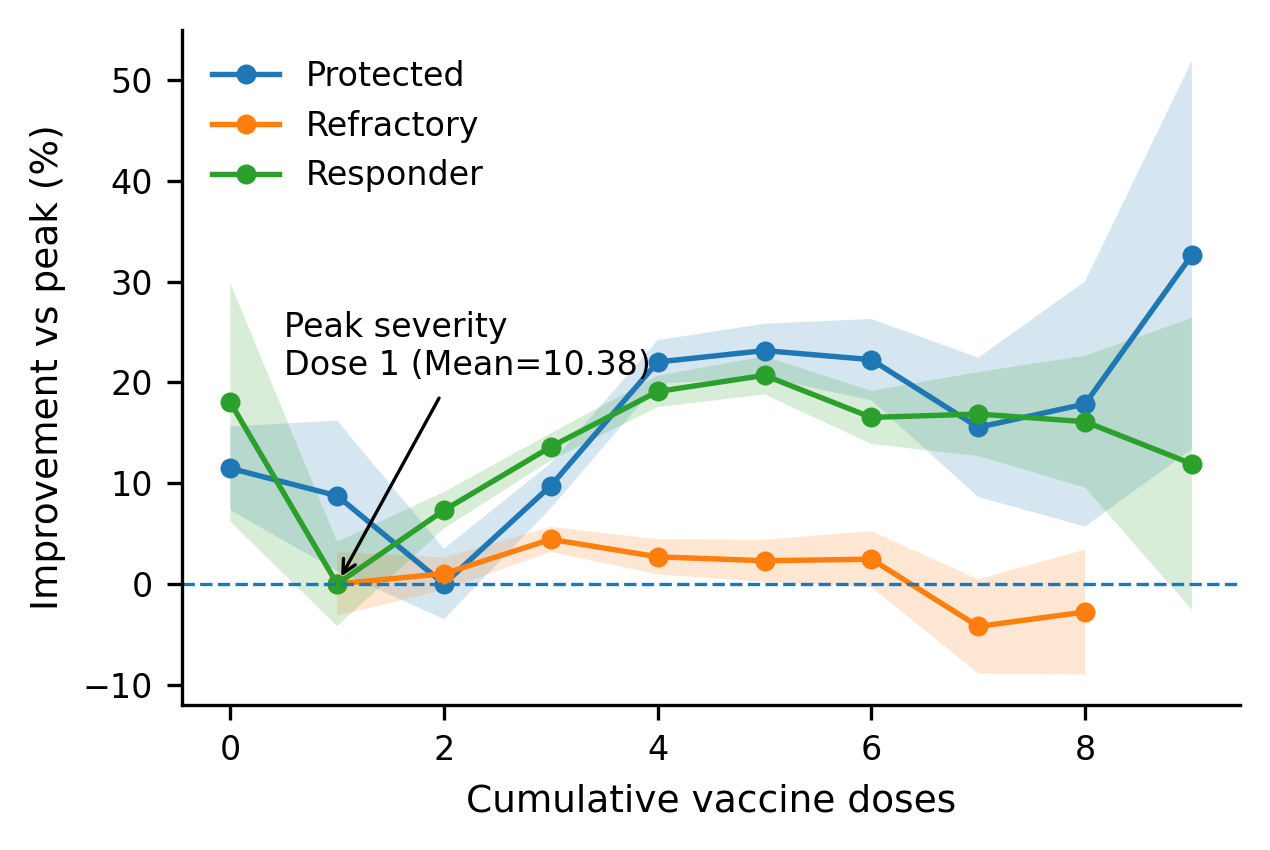

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------------
# Plot (Nature-ish minimalist)
# -------------------------
plt.rcParams.update({
    "font.family":"sans-serif",
    "font.sans-serif":["Helvetica","Arial","DejaVu Sans"],
    "pdf.fonttype":42,
    "axes.linewidth":0.8
})

fig, ax = plt.subplots(figsize=(4.2, 2.8), dpi=300)

for g, gdf in df_plot.groupby("group"):
    gdf = gdf.sort_values("dose")
    ax.plot(gdf["dose"], gdf["improve_pct"], marker="o", linewidth=1.3, markersize=3.8, label=g)
    ax.fill_between(gdf["dose"], gdf["low"], gdf["high"], alpha=0.18)

# 0% = cohort peak
ax.axhline(0, linestyle="--", linewidth=0.8)

# Annotate responder peak
rpeak = df2[(df2["group"]=="Responder") & (df2["dose"]==1)].iloc[0]
ax.annotate(
    f"Peak severity\nDose 1 (Mean={rpeak['peak_mean']:.2f})",
    xy=(1, 0), xytext=(0.5, 20),
    arrowprops=dict(arrowstyle="->", linewidth=0.8),
    fontsize=8, ha="left", va="bottom"
)

ax.set_xlabel("Cumulative vaccine doses", fontsize=9)
ax.set_ylabel("Improvement vs peak (%)", fontsize=9)
ax.tick_params(direction="out", length=3.5, width=0.8, labelsize=8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False, fontsize=8, loc="upper left")

fig.tight_layout(pad=0.6)
fig.savefig("DoseResponse_Improvement_AllGroups_95CI.pdf", bbox_inches="tight")
plt.show()

In [7]:
df = pasc_df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.rename(columns={"name": "pasc_score"})   # rename for clarity
df = df.sort_values(["id", "date"])
protected_set  = set(protected_ids)
responder_set  = set(responder_ids)
refractory_set = set(refractory_ids)

def id_to_group(pid):
    if pid in protected_set:  return "Protected"
    if pid in responder_set:  return "Responder"
    if pid in refractory_set: return "Refractory"
    return np.nan

df["group_name"] = df["id"].map(id_to_group)
df = df.dropna(subset=["group_name"])
idx_peak = df.groupby("id")["pasc_score"].idxmax()
peak_df = (
    df.loc[idx_peak, ["id", "group_name", "date", "pasc_score"]]
      .rename(columns={"date":"peak_date", "pasc_score":"peak_pasc"})
      .reset_index(drop=True)
)
if "prior_vax_count" in df.columns:
    base_dose_df = (
        df.groupby("id", as_index=False)
          .first()[["id","prior_vax_count"]]
          .rename(columns={"prior_vax_count":"baseline_vax_doses"})
    )
else:
    base_dose_df = None
# pasc_df.head()
initial_df = (
    df.groupby("id", as_index=False)
      .first()[["id", "group_name", "date", "pasc_score"]]
      .rename(columns={"date":"initial_date", "pasc_score":"initial_pasc"})
)
df_individual = initial_df.merge(peak_df, on=["id","group_name"], how="inner")

if base_dose_df is not None:
    df_individual = df_individual.merge(base_dose_df, on="id", how="left")

# Optional: keep only the 3 cohorts, ordered labels
df_individual["group_name"] = pd.Categorical(
    df_individual["group_name"],
    categories=["Protected","Responder","Refractory"],
    ordered=True
)

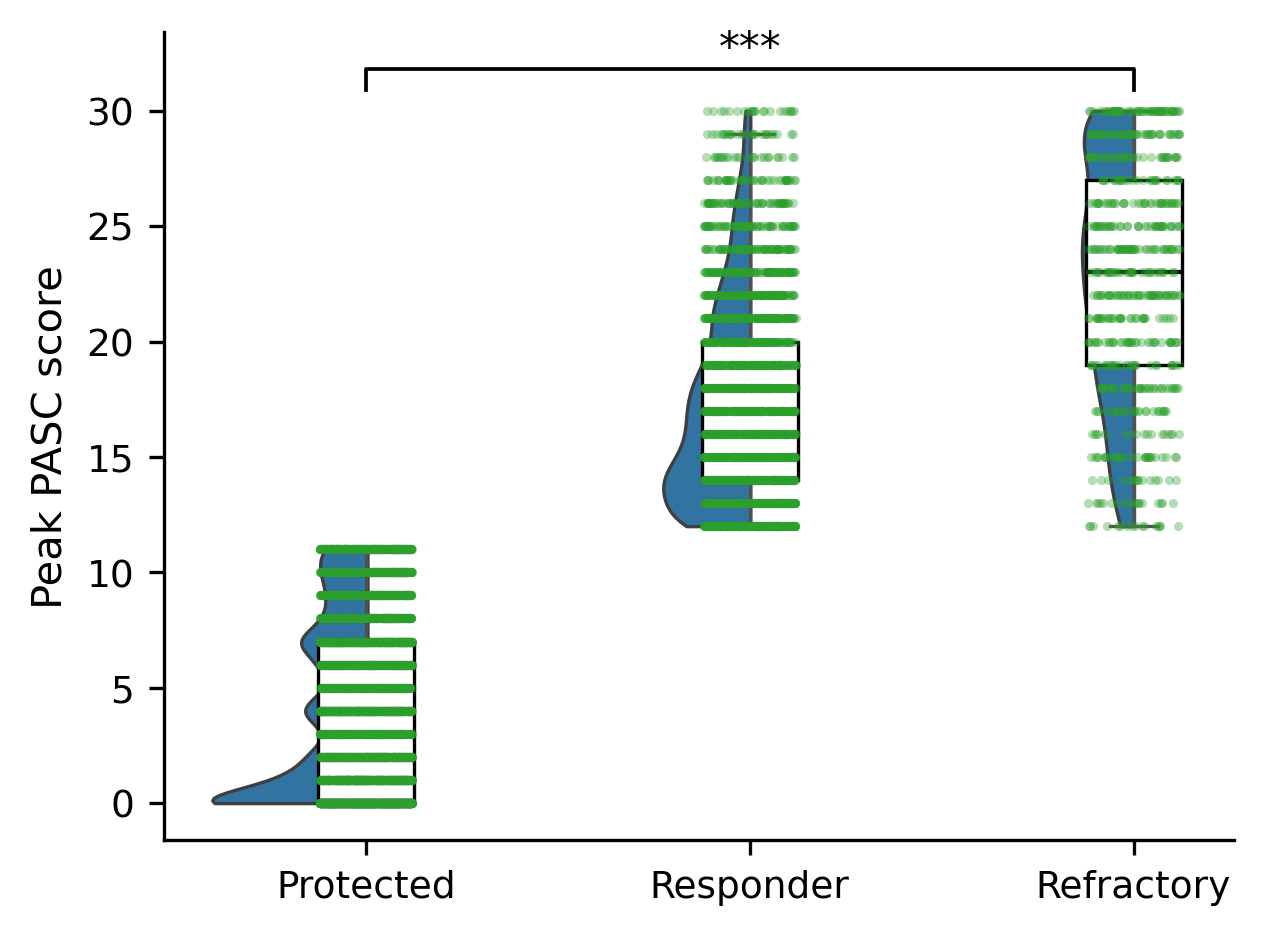

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# -------------------------
# Style (Nature-ish)
# -------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8,
})

ORDER = ["Protected", "Responder", "Refractory"]

def make_half_violin(ax, side="left"):
    """
    Convert full violins drawn by seaborn.violinplot into half violins.
    side: "left" or "right" relative to the category centerline.
    """
    for c in ax.collections:
        if isinstance(c, PolyCollection):
            paths = c.get_paths()
            for p in paths:
                verts = p.vertices
                # violin is centered at x ~ category position; clip to one side
                x_center = np.mean(verts[:, 0])
                if side == "left":
                    verts[:, 0] = np.minimum(verts[:, 0], x_center)
                else:
                    verts[:, 0] = np.maximum(verts[:, 0], x_center)

def add_sig_bracket(ax, x1, x2, y, h, text="***", lw=0.9):
    """
    Add significance bracket between category indices x1 and x2.
    """
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="black", clip_on=False)
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=10)

def raincloud(ax, df, y, x="group_name", order=ORDER,
              violin_side="left", jitter=0.12):
    """
    Raincloud = half violin + box + raw points.
    df must contain individual-level values in column y.
    """
    # Half violin (no inner)
    sns.violinplot(
        data=df, x=x, y=y, order=order,
        inner=None, cut=0, linewidth=0.8,
        ax=ax
    )
    make_half_violin(ax, side=violin_side)

    # Boxplot (thin, on top)
    sns.boxplot(
        data=df, x=x, y=y, order=order,
        width=0.25, showcaps=True, showfliers=False,
        boxprops={"facecolor":"white", "edgecolor":"black", "linewidth":0.8},
        whiskerprops={"linewidth":0.8},
        capprops={"linewidth":0.8},
        medianprops={"color":"black", "linewidth":1.0},
        ax=ax
    )

    # Raw points (cloud)
    sns.stripplot(
        data=df, x=x, y=y, order=order,
        size=2.2, jitter=jitter, alpha=0.35,
        edgecolor=None, linewidth=0,
        ax=ax
    )

    # Clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="out", length=3.5, width=0.8, labelsize=9)
    ax.set_xlabel("")
    return ax

# -------------------------
# Example usage
# -------------------------
# REQUIRED: df_individual must have individual rows, e.g.:
# df_individual columns:
#   group_name in {"Protected","Responder","Refractory"}
#   peak_pasc (per patient peak), initial_pasc (per patient), avg_vax_doses (per patient)
#
# df_individual = ...

fig, ax = plt.subplots(figsize=(4.2, 3.1), dpi=300)

# Choose which Table 3 continuous feature to plot:
# 1) Peak PASC Score
raincloud(ax, df_individual, y="peak_pasc")

ax.set_ylabel("Peak PASC score", fontsize=10)

# Significance bracket across all 3 groups (overall p < 0.001 from Table 3)
ymax = np.nanmax(df_individual["peak_pasc"])
add_sig_bracket(ax, x1=0, x2=2, y=ymax*1.03, h=ymax*0.03, text="***")

fig.tight_layout(pad=0.6)
fig.savefig("Table3_PeakPASC_Raincloud.pdf", bbox_inches="tight")
plt.show()


/tmp/ipykernel_321/2414516228.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_321/2414516228.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


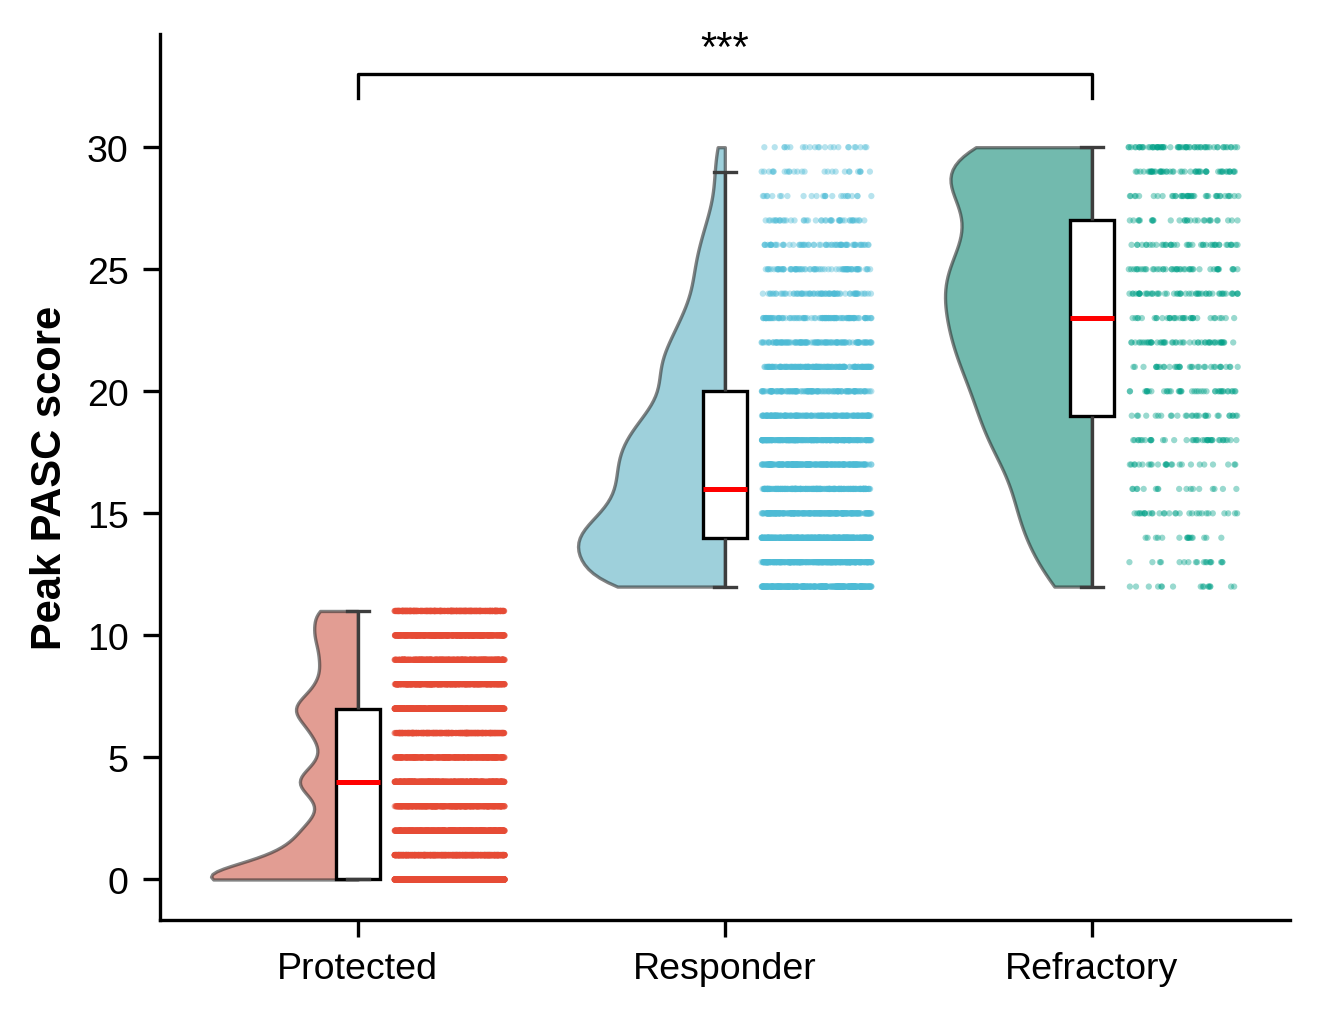

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# -------------------------
# Style (Nature-Standard)
# -------------------------
# plt.rcParams.update({
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Arial", "Helvetica"],
#     "pdf.fonttype": 42,
#     "axes.linewidth": 0.8,
#     "xtick.major.width": 0.8,
#     "ytick.major.width": 0.8
# })
plt.rcParams.update({
    "font.family": "sans-serif",
    # Put common Linux fonts + Matplotlib default at the end
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
})
ORDER = ["Protected", "Responder", "Refractory"]
COLORS = ['#E64B35FF', '#4DBBD5FF', '#00A087FF'] # Your NPG colors

def raincloud_nature(ax, df, y, x="group_name", order=ORDER, colors=COLORS):
    # 1. Violin Plot (Cloud) - Shifted to the left
    # We use 'half' logic by drawing and then clipping
    sns.violinplot(
        data=df, x=x, y=y, order=order, palette=colors,
        inner=None, cut=0, linewidth=0.8, ax=ax, alpha=0.6
    )
    
    for i, collection in enumerate(ax.collections):
        if isinstance(collection, PolyCollection):
            for path in collection.get_paths():
                verts = path.vertices
                center = i  # Category center
                # Clip to the left half
                verts[:, 0] = np.minimum(verts[:, 0], center)

    # 2. Stripplot (Rain) - Shifted to the right
    # We manually adjust the x-position of the points to avoid overlap
    sns.stripplot(
        data=df, x=x, y=y, order=order, palette=colors,
        size=1.5, alpha=0.4, jitter=0.15, marker='o', 
        linewidth=0, ax=ax
    )
    
    # Move the points to the right of the center
    for i, collection in enumerate(ax.collections):
        if not isinstance(collection, PolyCollection):
            # These are the PathCollections (dots)
            offsets = collection.get_offsets()
            offsets[:, 0] += 0.25 # Shift points to the right
            collection.set_offsets(offsets)

    # 3. Boxplot - Centered and thin
    sns.boxplot(
        data=df, x=x, y=y, order=order,
        width=0.12, showcaps=True, showfliers=False,
        boxprops={"facecolor": "white", "edgecolor": "black", "linewidth": 0.8, "zorder": 10},
        whiskerprops={"linewidth": 0.8, "zorder": 10},
        capprops={"linewidth": 0.8, "zorder": 10},
        medianprops={"color": "red", "linewidth": 1.2, "zorder": 11}, # Red median for visibility
        ax=ax
    )

    # Clean Spines
    sns.despine()
    ax.tick_params(direction="out", length=4, labelsize=9)
    ax.set_xlabel("")
    return ax

# -------------------------
# Execution
# -------------------------
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=300)

# Replace df_individual with your actual dataframe
raincloud_nature(ax, df_individual, y="peak_pasc")

ax.set_ylabel("Peak PASC score", fontsize=10, fontweight='bold')

# Significance bracket using the exact values from Table 3
# Protected vs Refractory (Overall p < 0.001)
ymax = df_individual["peak_pasc"].max()
y_pos = ymax + 2
ax.plot([0, 0, 2, 2], [y_pos, y_pos+1, y_pos+1, y_pos], lw=0.8, c="black")
ax.text(1, y_pos+1.2, "***", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("Nature_Raincloud_PeakPASC.pdf", format='pdf')
plt.show()

In [9]:
df_individual.head()

,id,group_name,initial_date,initial_pasc,peak_date,peak_pasc,baseline_vax_doses
0,RA11,Responder,2022-01-02,10.0,2022-09-15,24.0,3
1,RA110,Protected,2023-01-18,4.0,2023-01-18,4.0,4
2,RA1100,Protected,2022-01-01,11.0,2022-01-01,11.0,2
3,RA11000,Protected,2022-01-04,0.0,2022-10-02,6.0,4
4,RA110000,Protected,2022-01-01,3.0,2022-07-14,6.0,3


/tmp/ipykernel_321/2414516228.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_321/2414516228.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


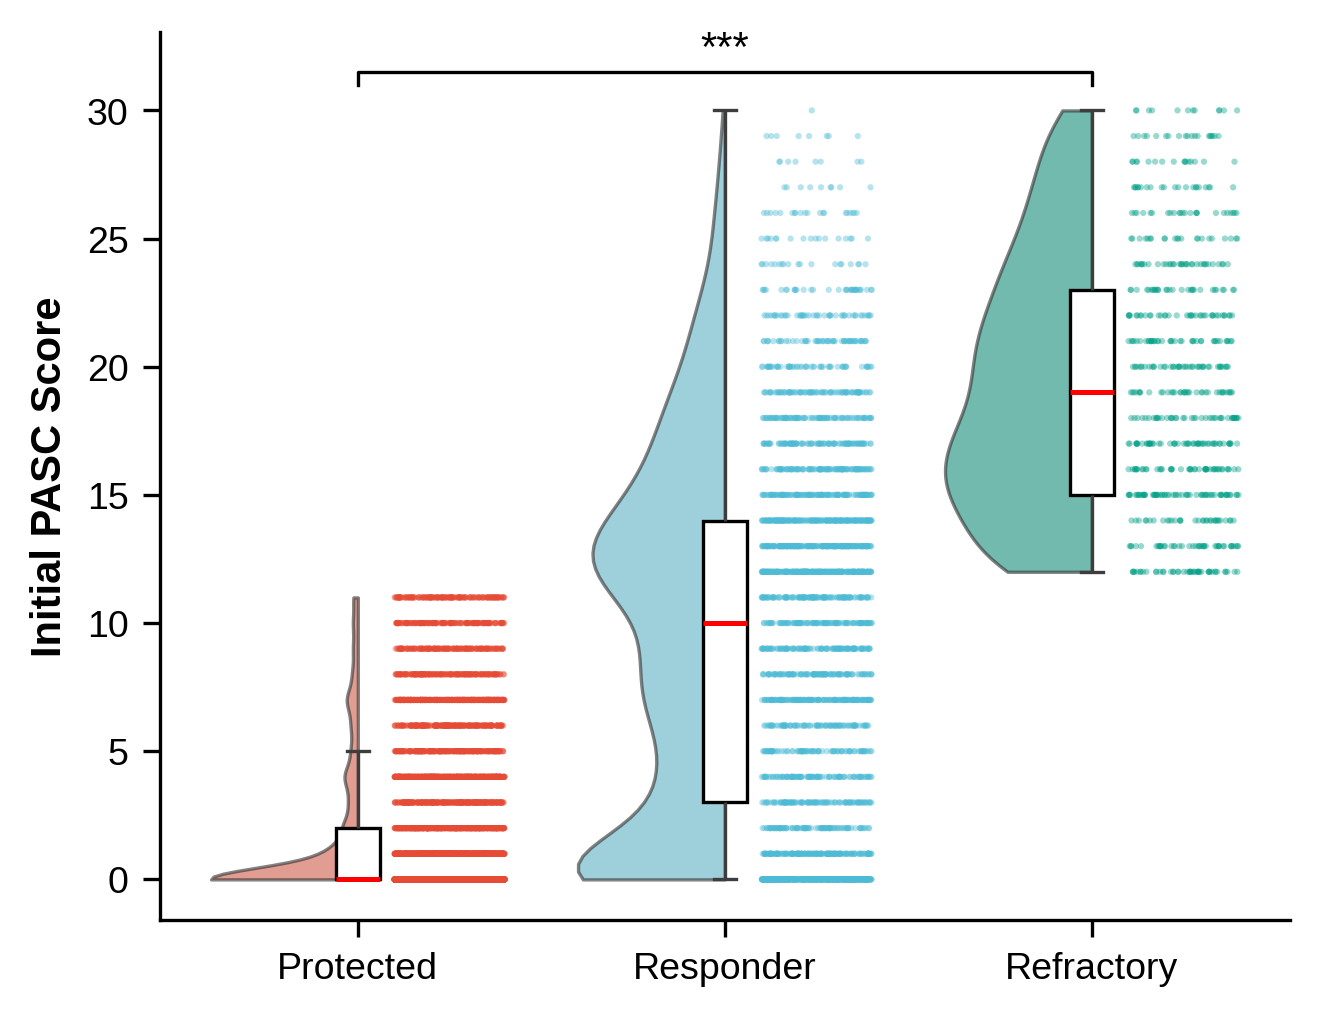

In [11]:
# Create the figure
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=300)

# 1. Plot the Raincloud for Initial Scores
# Ensure 'initial_pasc' is the column containing scores at enrollment/index 0
raincloud_nature(ax, df_individual, y="initial_pasc")

# 2. Nature-style Labeling
ax.set_ylabel("Initial PASC Score", fontsize=10, fontweight='bold')
# plt.title("Baseline Severity at Enrollment", fontsize=11, pad=15)

# 3. Significance Bracket (ANOVA/Kruskal-Wallis p < 0.001 from Table 3)
# Set y_pos based on the distribution of initial scores
ymax = df_individual["initial_pasc"].max()
y_pos = ymax + 1
ax.plot([0, 0, 2, 2], [y_pos, y_pos + 0.5, y_pos + 0.5, y_pos], lw=0.8, c="black")
ax.text(1, y_pos + 0.6, "***", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("Nature_Raincloud_InitialPASC.pdf", format='pdf')
plt.show()

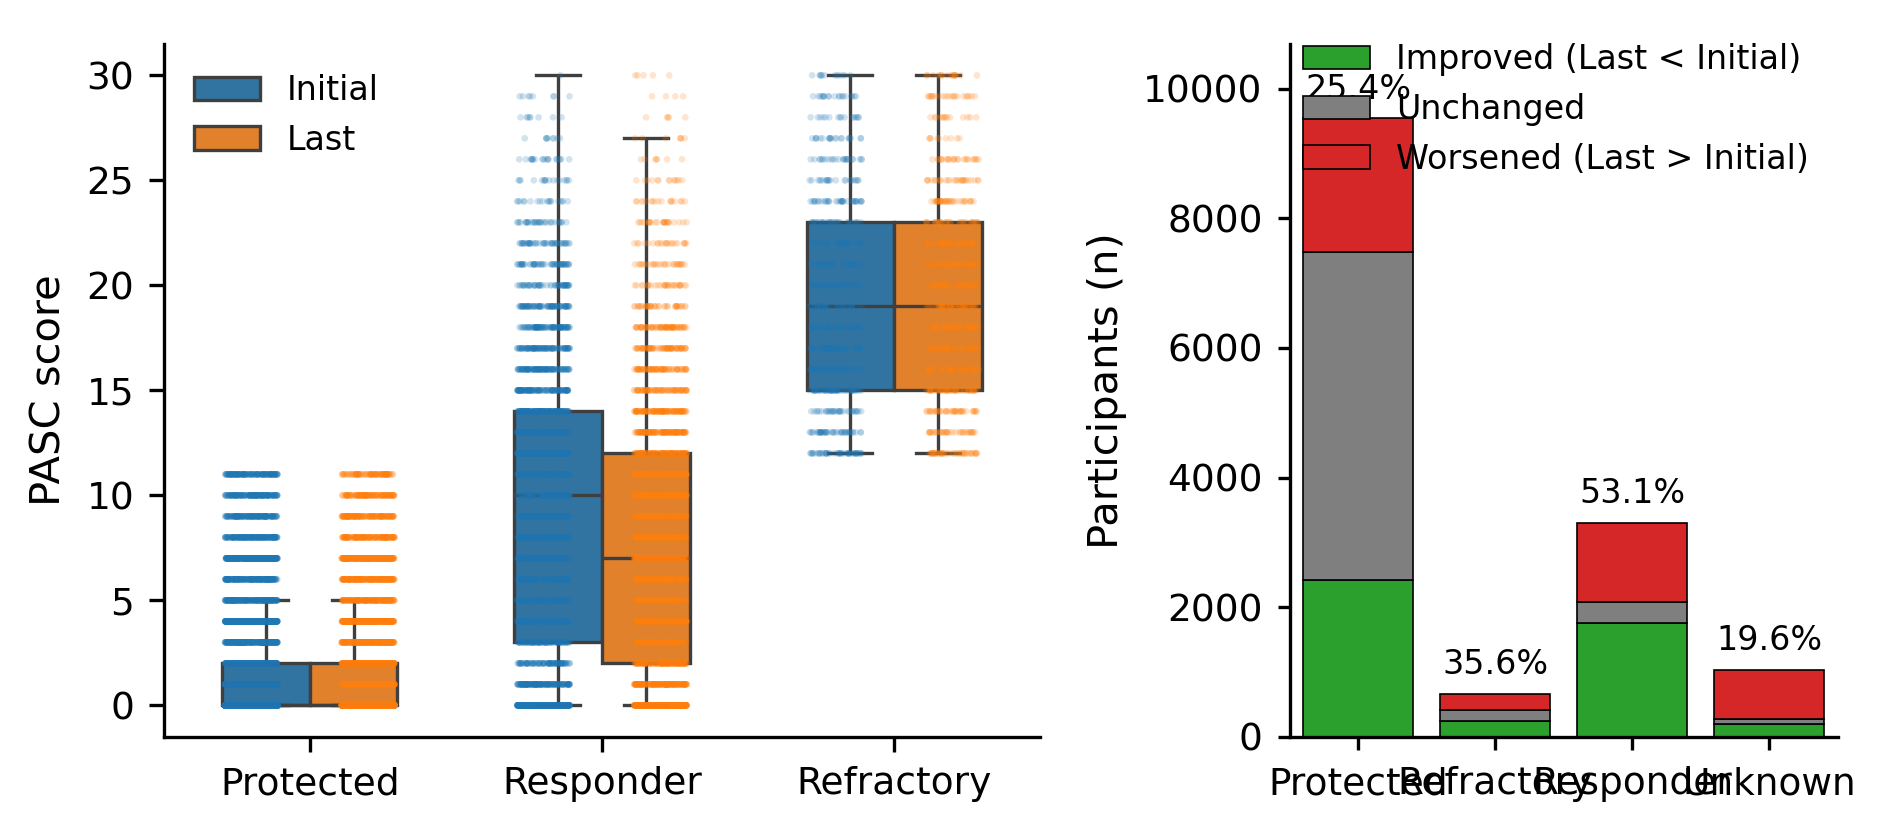

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pasc_df.copy()
conditions = [
    df['id'].isin(protected_ids),
    df['id'].isin(responder_ids),
    df['id'].isin(refractory_ids)
]
choices = ['Protected', 'Responder', 'Refractory']

# Create the new 'group' column
# The 'default' parameter is for any ID that doesn't match the lists
df['group'] = np.select(conditions, choices, default='Unknown')

# df_long must have: id, date, pasc_score, group_name
df_long = df.copy()
df_long["date"] = pd.to_datetime(df_long["date"])
df_long = df_long.sort_values(["id", "date"])

# Per-person summary
g = df_long.groupby("id", as_index=False)

df_initial = g.first()[["id", "group", "date", "name"]].rename(
    columns={"date": "initial_date", "name": "initial_pasc"}
)

df_last = g.last()[["id", "date", "name"]].rename(
    columns={"date": "last_date", "name": "last_pasc"}
)

df_min = g["name"].min().rename(columns={"pasc_score": "min_pasc"})
df_max = g["name"].max().rename(columns={"pasc_score": "peak_pasc"})  # matches Table 3 “Peak PASC”

df_nvis = g.size().rename(columns={"size": "n_visits"})

df_individual = (
    df_initial
    .merge(df_last, on="id", how="inner")
    .merge(df_min, on="id", how="left")
    .merge(df_max, on="id", how="left")
    .merge(df_nvis, on="id", how="left")
)

# Improvement direction based on LAST vs INITIAL
df_individual["delta_last_minus_initial"] = df_individual["last_pasc"] - df_individual["initial_pasc"]

df_individual["outcome"] = np.select(
    [
        df_individual["delta_last_minus_initial"] < 0,
        df_individual["delta_last_minus_initial"] > 0
    ],
    ["Improved (Last < Initial)", "Worsened (Last > Initial)"],
    default="Unchanged"
)

ORDER = ["Protected", "Responder", "Refractory"]
df_individual["group_name"] = pd.Categorical(df_individual["group"], categories=ORDER, ordered=True)


# Colors (you explicitly asked for green/red)
COL_IMPROVE = "#2ca02c"  # green
COL_WORSEN  = "#d62728"  # red
COL_SAME    = "#7f7f7f"  # gray

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8,
})

# ---- reshape for Panel A ----
plot_a = df_individual.melt(
    id_vars=["id", "group"],
    value_vars=["initial_pasc", "last_pasc"],   # add "min_pasc" here if you want
    var_name="timepoint",
    value_name="pasc"
)
plot_a["timepoint"] = plot_a["timepoint"].map({
    "initial_pasc": "Initial",
    "last_pasc": "Last",
    # "min_pasc": "Minimum"
})

# Optional: reduce overplotting if huge N
# plot_a_points = plot_a.groupby(["group_name","timepoint"], group_keys=False)\
#                       .apply(lambda d: d.sample(n=min(len(d), 1500), random_state=1))

fig = plt.figure(figsize=(7.2, 3.0), dpi=300)
gs = fig.add_gridspec(1, 2, width_ratios=[1.6, 1.0], wspace=0.35)

# ---------------- Panel A ----------------
ax1 = fig.add_subplot(gs[0, 0])

sns.boxplot(
    data=plot_a, x="group", y="pasc", hue="timepoint",
    order=ORDER, hue_order=["Initial", "Last"],
    width=0.6, fliersize=0, linewidth=0.8, ax=ax1
)

sns.stripplot(
    data=plot_a, x="group", y="pasc", hue="timepoint",
    order=ORDER, hue_order=["Initial", "Last"],
    dodge=True, jitter=0.18, size=1.6, alpha=0.20, ax=ax1
)

# Clean legend (avoid duplicate legends from stripplot)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], frameon=False, fontsize=8, title=None, loc="upper left")

ax1.set_xlabel("")
ax1.set_ylabel("PASC score", fontsize=10)
ax1.tick_params(direction="out", length=3.5, width=0.8, labelsize=9)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# ---------------- Panel B ----------------
ax2 = fig.add_subplot(gs[0, 1])

counts = (df_individual
          .groupby(["group", "outcome"])
          .size()
          .unstack(fill_value=0)
         )

# Ensure consistent column order
for col in ["Improved (Last < Initial)", "Unchanged", "Worsened (Last > Initial)"]:
    if col not in counts.columns:
        counts[col] = 0
counts = counts[["Improved (Last < Initial)", "Unchanged", "Worsened (Last > Initial)"]]

# Plot stacked bars (counts)
bottom = np.zeros(len(counts))
x = np.arange(len(counts))

colors = [COL_IMPROVE, COL_SAME, COL_WORSEN]
for i, col in enumerate(counts.columns):
    ax2.bar(x, counts[col].values, bottom=bottom, color=colors[i], edgecolor="black", linewidth=0.4, label=col)
    bottom += counts[col].values
# ---- Axis formatting (Nature-ish) ----
ax2.set_xticks(x)
ax2.set_xticklabels(counts.index.tolist(), fontsize=9)

ax2.set_ylabel("Participants (n)", fontsize=10)
ax2.set_xlabel("")

# tight x-limits so labels don’t crash into the axis frame
ax2.set_xlim(-0.5, len(x) - 0.5)

# Outward ticks, moderate length
ax2.tick_params(axis="both", direction="out", length=3, width=0.8, labelsize=9)
ax2.tick_params(axis="x", pad=4)

# Only left + bottom spines (clean)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# No grid by default in Nature style (optional: very light y-grid if you want)
# ax2.yaxis.grid(True, linewidth=0.3, alpha=0.25)
# ax2.set_axisbelow(True)

# Y-limit with headroom for percentage labels + bracket if needed
ymax = counts.sum(axis=1).max()
ax2.set_ylim(0, ymax * 1.12)

# Legend: outside or above to avoid covering bars
ax2.legend(
    frameon=False,
    fontsize=8,
    loc="upper left",
    bbox_to_anchor=(0.0, 1.02),
    borderaxespad=0.0,
    ncol=1
)

# ---- Percent improvement labels (clean placement) ----
totals = counts.sum(axis=1).values
improved = counts["Improved (Last < Initial)"].values
pct = improved / np.maximum(totals, 1) * 100

# consistent vertical offset in data units
y_offset = ymax * 0.02

for xi, total, p in zip(x, totals, pct):
    if total == 0:
        continue
    ax2.text(
        xi, total + y_offset,
        f"{p:.1f}%",
        ha="center", va="bottom",
        fontsize=8
    )

# Optional: if you have an "Unknown" group and don't want it, drop before plotting:
counts = counts.drop(index=["Unknown"], errors="ignore")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 0) Prepare long df + groups
# ---------------------------
df = pasc_df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["id", "date"])

conditions = [
    df["id"].isin(protected_ids),
    df["id"].isin(responder_ids),
    df["id"].isin(refractory_ids)
]
choices = ["Protected", "Responder", "Refractory"]
df["group"] = np.select(conditions, choices, default="Unknown")

# ---------------------------
# 1) Build df_individual (1 row per id)
# ---------------------------
g = df.groupby("id", as_index=False)

df_initial = g.first()[["id", "group", "date", "name"]].rename(
    columns={"date": "initial_date", "name": "initial_pasc"}
)
df_last = g.last()[["id", "date", "name"]].rename(
    columns={"date": "last_date", "name": "last_pasc"}
)

df_min = g["name"].min().rename(columns={"name": "min_pasc"})     # columns: id, min_pasc
df_max = g["name"].max().rename(columns={"name": "peak_pasc"})    # columns: id, peak_pasc
df_nvis = g.size().rename(columns={"size": "n_visits"})           # columns: id, n_visits

df_individual = (
    df_initial
    .merge(df_last, on="id", how="inner")
    .merge(df_min, on="id", how="left")
    .merge(df_max, on="id", how="left")
    .merge(df_nvis, on="id", how="left")
)

# time gap (days) between initial and last
df_individual["gap_days"] = (df_individual["last_date"] - df_individual["initial_date"]).dt.days

# improvement direction based on LAST vs INITIAL
df_individual["delta_last_minus_initial"] = df_individual["last_pasc"] - df_individual["initial_pasc"]
df_individual["outcome"] = np.select(
    [df_individual["delta_last_minus_initial"] < 0,
     df_individual["delta_last_minus_initial"] > 0],
    ["Improved (Last < Initial)", "Worsened (Last > Initial)"],
    default="Unchanged"
)

ORDER = ["Protected", "Responder", "Refractory"]
df_individual["group"] = pd.Categorical(df_individual["group"], categories=ORDER + ["Unknown"], ordered=False)

# Drop Unknown for the paper plot (recommended)
df_ind_plot = df_individual[df_individual["group"].isin(ORDER)].copy()
df_ind_plot["group"] = pd.Categorical(df_ind_plot["group"], categories=ORDER, ordered=True)

# ---------------------------
# 2) Plot settings (Nature-ish)
# ---------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

COL_IMPROVE = "#2ca02c"
COL_WORSEN  = "#d62728"
COL_SAME    = "#7f7f7f"

# ---------------------------
# 3) Build Panel A data (Initial vs Last)
# ---------------------------
plot_a = df_ind_plot.melt(
    id_vars=["id", "group"],
    value_vars=["initial_pasc", "last_pasc"],
    var_name="timepoint",
    value_name="pasc"
)
plot_a["timepoint"] = plot_a["timepoint"].map({"initial_pasc": "Initial", "last_pasc": "Last"})


/tmp/ipykernel_321/1553488003.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_a_pts = (plot_a.groupby(["group","timepoint"], group_keys=False)
/tmp/ipykernel_321/1553488003.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.sample(n=min(len(d), 1200), random_state=1)))
/tmp/ipykernel_321/1553488003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

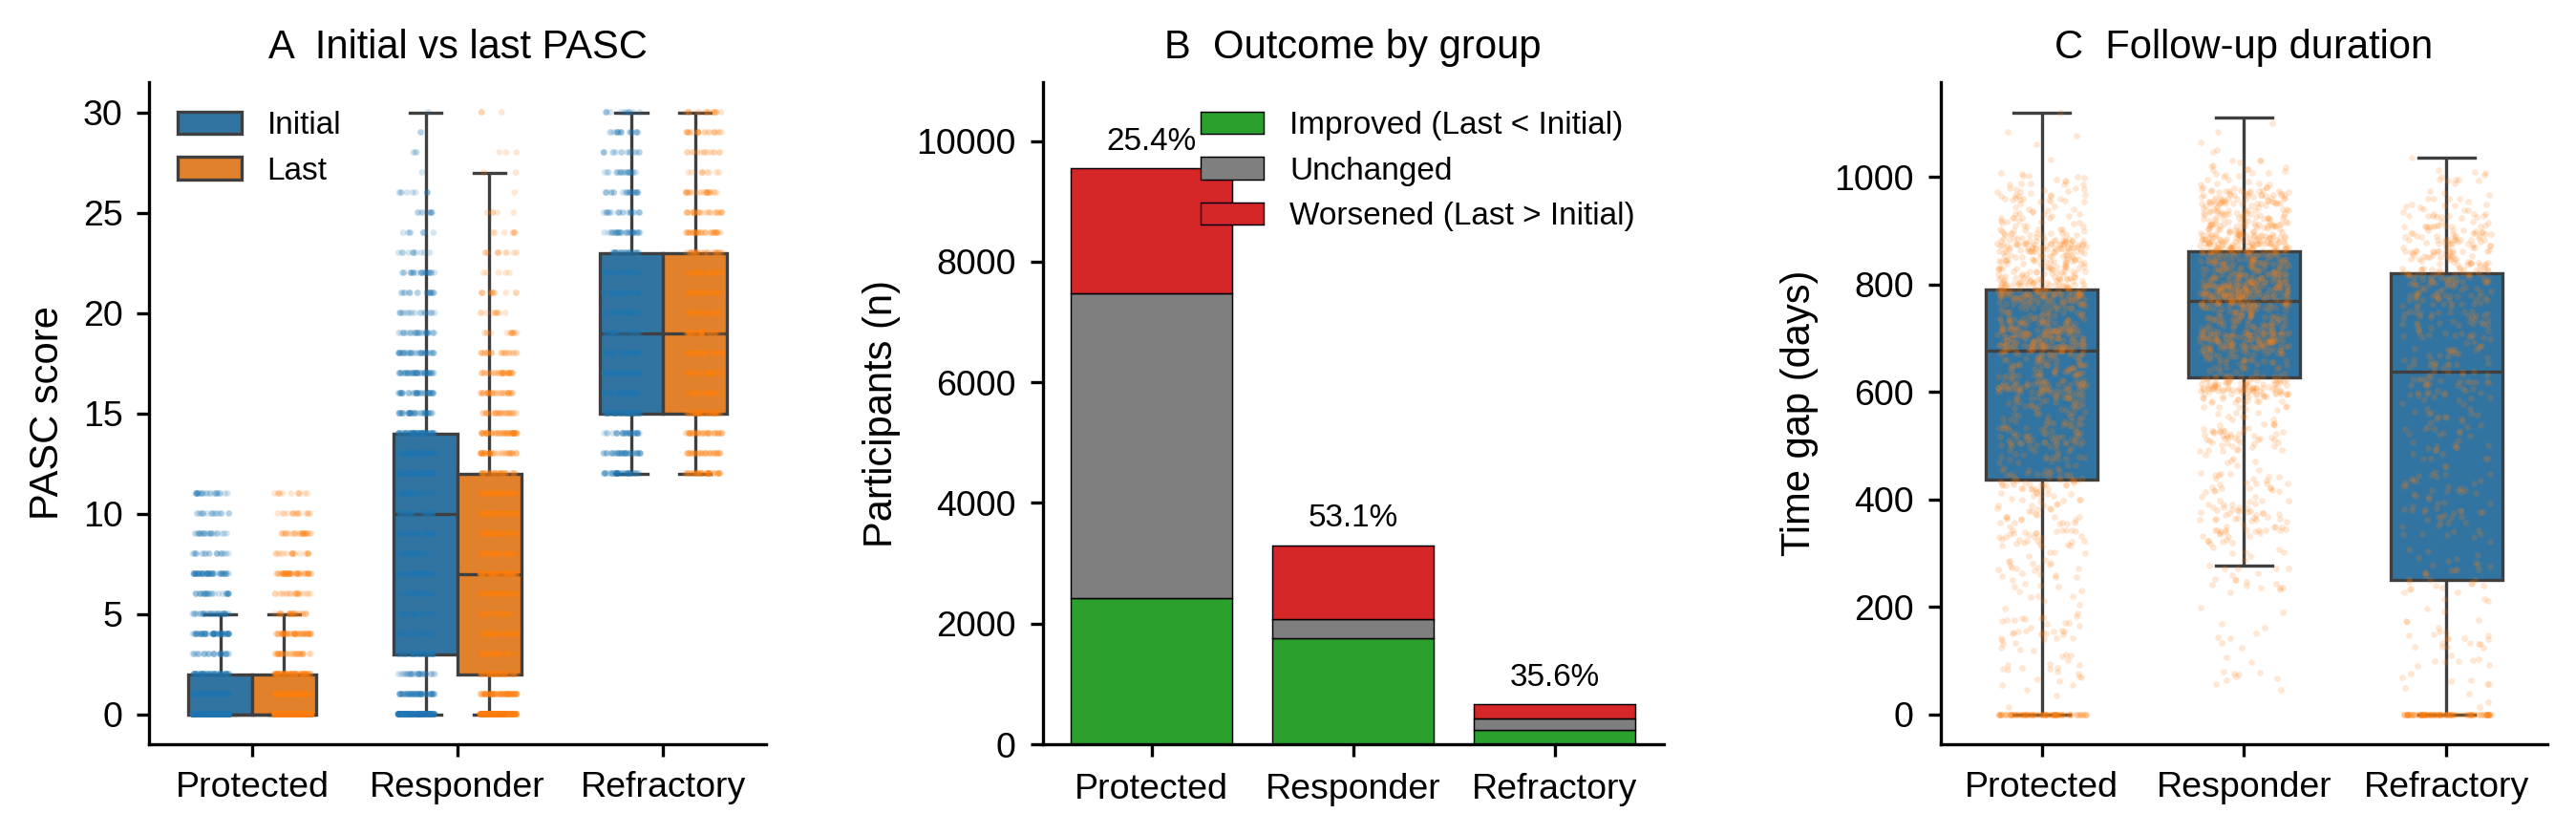

In [25]:

# ---------------------------
# 4) Figure with 3 subfigures
#    Make ax2 wider using width_ratios
# ---------------------------
# fig = plt.figure(figsize=(10.2, 3.0), dpi=300)
# gs = fig.add_gridspec(1, 3, width_ratios=[1.55, 1.25, 1.10], wspace=0.45)
fig = plt.figure(figsize=(10.8, 3.0), dpi=300)
gs = fig.add_gridspec(1, 3, width_ratios=[1.32, 1.33, 1.30], wspace=0.45)

# ---------- Panel A ----------
ax1 = fig.add_subplot(gs[0, 0])

sns.boxplot(
    data=plot_a, x="group", y="pasc", hue="timepoint",
    order=ORDER, hue_order=["Initial", "Last"],
    width=0.62, fliersize=0, linewidth=0.8, ax=ax1
)
# subsample points to avoid overplotting
plot_a_pts = (plot_a.groupby(["group","timepoint"], group_keys=False)
                    .apply(lambda d: d.sample(n=min(len(d), 1200), random_state=1)))

sns.stripplot(
    data=plot_a_pts, x="group", y="pasc", hue="timepoint",
    order=ORDER, hue_order=["Initial", "Last"],
    dodge=True, jitter=0.18, size=1.6, alpha=0.18, ax=ax1
)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], frameon=False, fontsize=8, title=None, loc="upper left")

ax1.set_xlabel("")
ax1.set_ylabel("PASC score", fontsize=10)
ax1.tick_params(direction="out", length=3.2, width=0.8, labelsize=9)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_title("A  Initial vs last PASC", fontsize=10, pad=6)

# ---------- Panel B ----------
ax2 = fig.add_subplot(gs[0, 1])

counts = (df_ind_plot
          .groupby(["group", "outcome"])
          .size()
          .unstack(fill_value=0)
         )

# Ensure consistent column order
col_improve = "Improved (Last < Initial)"
col_same    = "Unchanged"
col_worsen  = "Worsened (Last > Initial)"
for col in [col_improve, col_same, col_worsen]:
    if col not in counts.columns:
        counts[col] = 0
counts = counts[[col_improve, col_same, col_worsen]]

# Nature-ish palette (green/gray/red)
COL_IMPROVE = "#2ca02c"
COL_SAME    = "#7f7f7f"
COL_WORSEN  = "#d62728"
palette = [COL_IMPROVE, COL_SAME, COL_WORSEN]

bottom = np.zeros(len(counts))
x = np.arange(len(counts))

# Slightly lighter stroke for Nature style
for i, col in enumerate(counts.columns):
    ax2.bar(
        x, counts[col].values, bottom=bottom,
        color=palette[i],
        edgecolor="black", linewidth=0.35,
        label=col
    )
    bottom += counts[col].values

ax2.set_xticks(x)
ax2.set_xticklabels(counts.index.tolist(), fontsize=9)
ax2.set_ylabel("Participants (n)", fontsize=10)
ax2.set_xlabel("")
ax2.tick_params(axis="both", direction="out", length=3.2, width=0.8, labelsize=9)
ax2.tick_params(axis="x", pad=4)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Headroom for labels
ymax = counts.sum(axis=1).max()
ax2.set_ylim(0, ymax * 1.15)

# Legend in upper right (inside), no frame
ax2.legend(frameon=False, fontsize=8, loc="upper right")

# Percent improved labels (above bars)
totals = counts.sum(axis=1).values
improved = counts[col_improve].values
pct = improved / np.maximum(totals, 1) * 100
y_offset = ymax * 0.02

for xi, total, p in zip(x, totals, pct):
    if total > 0:
        ax2.text(xi, total + y_offset, f"{p:.1f}%", ha="center", va="bottom", fontsize=8)

ax2.set_title("B  Outcome by group", fontsize=10, pad=6)
# ---------- Panel C (time gap) ----------
ax3 = fig.add_subplot(gs[0, 2])

# Often skewed; show median/IQR via box + light points
sns.boxplot(
    data=df_ind_plot, x="group", y="gap_days",
    order=ORDER, width=0.55, fliersize=0, linewidth=0.8, ax=ax3
)

df_gap_pts = (df_ind_plot.groupby("group", group_keys=False)
                      .apply(lambda d: d.sample(n=min(len(d), 1200), random_state=1)))

sns.stripplot(
    data=df_gap_pts, x="group", y="gap_days",
    order=ORDER, jitter=0.22, size=1.6, alpha=0.18, ax=ax3
)

ax3.set_xlabel("")
ax3.set_ylabel("Time gap (days)", fontsize=10)
ax3.tick_params(direction="out", length=3.2, width=0.8, labelsize=9)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title("C  Follow-up duration", fontsize=10, pad=6)

fig.tight_layout(pad=0.6)
fig.savefig("PASC_Initial_Last_Outcome_Gap_3panel.pdf", bbox_inches="tight")
plt.show()


In [29]:
pasc_df.head()

,id,index,date,name,prior_vax_count
0,RA11305,pasc,2021-01-01,16.0,3
1,RA11305,pasc,2021-04-03,14.0,3
2,RA11305,pasc,2021-06-28,8.0,3
3,RA11305,pasc,2021-09-28,13.0,3
4,RA11305,pasc,2021-12-23,10.0,4


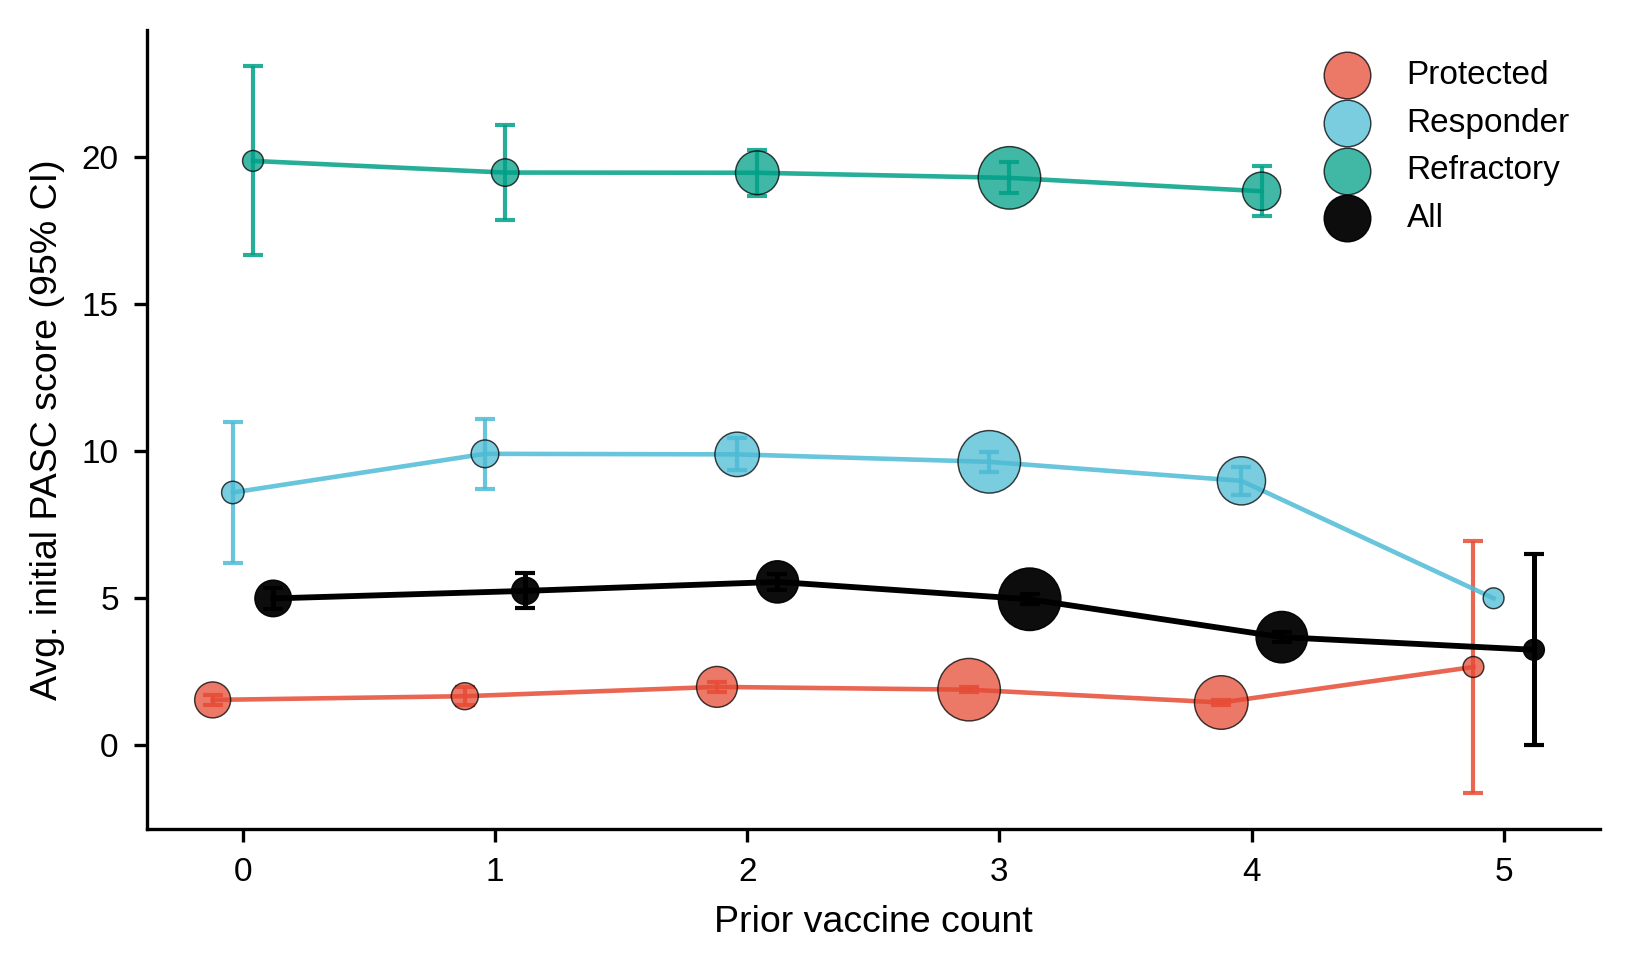

 prior_vax_count      mean      std    n      sem     ci95  pct_change_vs_prev      group
               0  4.994325 7.098360 1586 0.178241 0.349351                 NaN        All
               1  5.250903 7.122809  554 0.302619 0.593134            5.137374        All
               2  5.556584 7.042100 2377 0.144440 0.283102            5.821502        All
               3  4.966356 6.627202 6123 0.084693 0.165998          -10.622130        All
               4  3.679569 5.760330 3901 0.092227 0.180765          -25.910082        All
               5  3.250000 3.304038    4 1.652019 3.237957          -11.674446        All
               0  1.547475 2.799911  990 0.088987 0.174415                 NaN  Protected
               1  1.673529 2.841310  340 0.154092 0.302020            8.145830  Protected
               2  1.989444 3.103932 1421 0.082341 0.161388           18.877149  Protected
               3  1.895186 2.991091 3988 0.047364 0.092834           -4.737932  Protected
          

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
ID_COL    = "id"
DATE_COL  = "date"
DOSE_COL  = "prior_vax_count"
SCORE_COL = "name"   # <-- your PASC score column

ORDER = ["Protected", "Responder", "Refractory", "All"]
COLORS = {
    "Protected":  "#E64B35FF",
    "Responder":  "#4DBBD5FF",
    "Refractory": "#00A087FF",
    "All":        "black",
}

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

# ----------------------------
# Helper: build per-group summary for "initial at enrollment"
# ----------------------------
def summarize_initial_by_dose(df_in: pd.DataFrame, group_label: str) -> pd.DataFrame:
    df = df_in.copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])

    df = df.dropna(subset=[ID_COL, DATE_COL, DOSE_COL, SCORE_COL])
    df = df.sort_values([ID_COL, DATE_COL])

    # earliest record per person
    initial = df.groupby(ID_COL, as_index=False).first()

    # dose as int
    initial[DOSE_COL] = pd.to_numeric(initial[DOSE_COL], errors="coerce")
    initial = initial.dropna(subset=[DOSE_COL])
    initial[DOSE_COL] = initial[DOSE_COL].astype(int)

    summary = (initial.groupby(DOSE_COL)[SCORE_COL]
               .agg(mean="mean", std="std", n="count")
               .reset_index()
               .sort_values(DOSE_COL))

    summary["sem"] = summary["std"] / np.sqrt(summary["n"])
    summary["ci95"] = 1.96 * summary["sem"]
    summary["pct_change_vs_prev"] = summary["mean"].pct_change() * 100
    summary["group"] = group_label
    return summary


# ----------------------------
# Build summaries for each cohort + global (All)
# ----------------------------
df_all = pasc_df.copy()

df_prot = pasc_df[pasc_df["id"].isin(protected_ids)]
df_resp = pasc_df[pasc_df["id"].isin(responder_ids)]
df_refr = pasc_df[pasc_df["id"].isin(refractory_ids)]

summaries = [
    summarize_initial_by_dose(df_prot, "Protected"),
    summarize_initial_by_dose(df_resp, "Responder"),
    summarize_initial_by_dose(df_refr, "Refractory"),
    summarize_initial_by_dose(df_all,  "All"),
]

summary_all = pd.concat(summaries, ignore_index=True)

# ----------------------------
# Plot: one panel, multiple groups
#   - mean ± 95% CI by dose
#   - marker size encodes n (per group)
# ----------------------------
fig, ax = plt.subplots(figsize=(5.4, 3.2), dpi=300)

# small horizontal offsets so points don't overlap perfectly
offsets = {"Protected": -0.12, "Responder": -0.04, "Refractory": 0.04, "All": 0.12}

for grp in ORDER:
    s = summary_all[summary_all["group"] == grp].copy()
    if s.empty:
        continue

    x = s[DOSE_COL].to_numpy().astype(float) + offsets.get(grp, 0.0)
    y = s["mean"].to_numpy()
    yerr = s["ci95"].to_numpy()
    n = s["n"].to_numpy()

    # size scaling within group (keeps each series readable)
    if n.max() == n.min():
        sizes = np.full_like(n, 50, dtype=float)
    else:
        sizes = 25 + 200 * (n - n.min()) / (n.max() - n.min())

    # CI bars (no marker here)
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="none",
        capsize=2.5,
        linewidth=1.0 if grp != "All" else 1.2,
        color=COLORS[grp],
        alpha=0.85 if grp != "All" else 1.0,
        zorder=2 if grp != "All" else 3
    )

    # line + points
    ax.plot(
        x, y,
        linewidth=1.1 if grp != "All" else 1.4,
        color=COLORS[grp],
        alpha=0.85 if grp != "All" else 1.0,
        zorder=2 if grp != "All" else 3
    )
    ax.scatter(
        x, y,
        s=sizes,
        color=COLORS[grp],
        edgecolor="black",
        linewidth=0.35,
        alpha=0.75 if grp != "All" else 0.95,
        label=grp,
        zorder=3 if grp != "All" else 4
    )

# Styling
ax.set_xlabel("Prior vaccine count", fontsize=9)
ax.set_ylabel("Avg. initial PASC score (95% CI)", fontsize=9)
ax.tick_params(direction="out", length=3.2, width=0.8, labelsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Put legend in an unobtrusive place
ax.legend(frameon=False, fontsize=8, loc="upper right", title=None)

# Optional: make integer ticks only
ax.set_xticks(sorted(summary_all[DOSE_COL].unique()))

fig.tight_layout(pad=0.6)
fig.savefig("InitialPASC_byDose_AllGroups_and_Global.pdf", bbox_inches="tight")
plt.show()

# If you also want the table printed:
print(summary_all.sort_values(["group", DOSE_COL]).to_string(index=False))


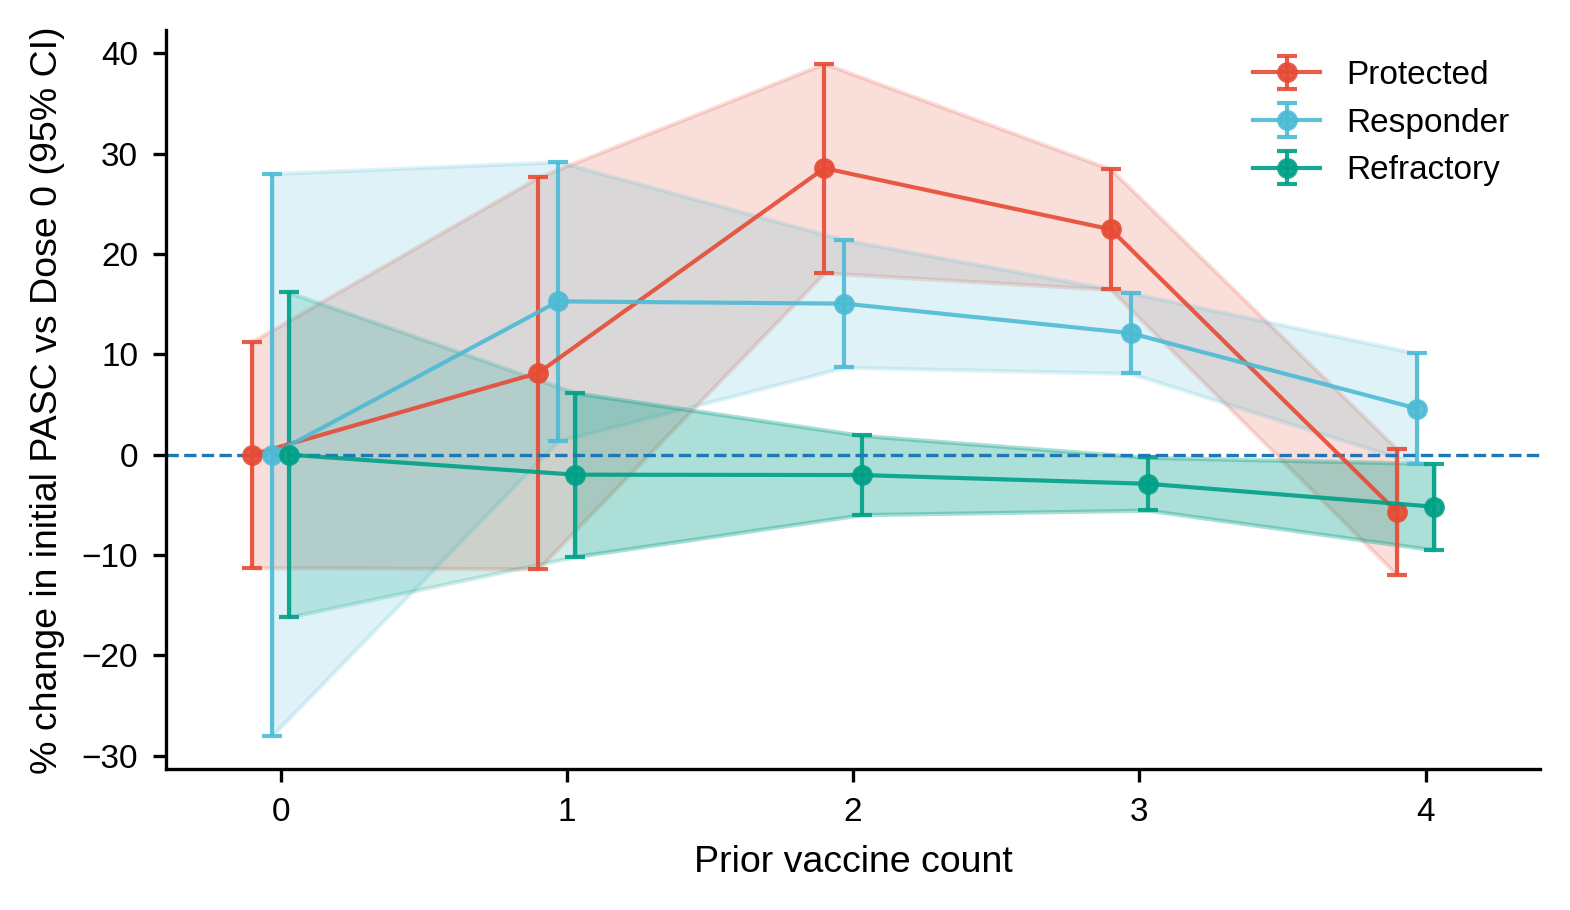

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Use the summary_all produced earlier (mean, ci95, group, prior_vax_count)
# Restrict to 0..4
dfp = summary_all[summary_all[DOSE_COL].between(0,4)].copy()

fig, ax = plt.subplots(figsize=(5.2, 3.0), dpi=300)

offsets = {"Protected": -0.10, "Responder": -0.03, "Refractory": 0.03, "All": 0.10}
colors = {"Protected":"#E64B35FF","Responder":"#4DBBD5FF","Refractory":"#00A087FF","All":"black"}

for grp in ["Protected","Responder","Refractory"]:#,"All"]:
    s = dfp[dfp["group"]==grp].sort_values(DOSE_COL).copy()
    if s.empty: 
        continue

    # baseline at dose 0
    if not (s[DOSE_COL] == 0).any():
        continue
    base_mean = float(s.loc[s[DOSE_COL]==0, "mean"].iloc[0])

    # Δ and %Δ (choose one)
    s["delta"] = s["mean"] - base_mean
    s["pct_delta"] = (s["mean"] - base_mean) / base_mean * 100.0

    x = s[DOSE_COL].to_numpy().astype(float) + offsets[grp]
    y = s["pct_delta"].to_numpy()   # <-- change to s["delta"] if you prefer Δ points
    yerr = (s["ci95"].to_numpy() / base_mean) * 100.0  # CI scaled into percent

    # ax.plot(x, y, marker="o", linewidth=1.4)
    # ci95 = s["ci95"].to_numpy()    # half-width in same units as y (%)
    ci95_pct = (s["ci95"].to_numpy() / base_mean) * 100.0   # half-width in %
    ax.fill_between(x, y - ci95_pct, y + ci95_pct, alpha=0.18, color=colors[grp])
    # ax.fill_between(x, y - ci95, y + ci95, alpha=0.18)
    # ax.fill_between(x, lower, upper, alpha=0.18)
    # ax.fill_between(x, y-low, y+high, alpha=0.18)

    ax.errorbar(x, y, yerr=yerr, fmt="o-", capsize=2.5,
                linewidth=1.0 if grp!="All" else 1.4,
                markersize=4, color=colors[grp], alpha=0.9,
                label=grp)
ask = s[DOSE_COL].to_numpy() > 0
ax.fill_between(x[mask], (y-ci95_pct)[mask], (y+ci95_pct)[mask], alpha=0.18, color=colors[grp])

ax.axhline(0, linestyle="--", linewidth=0.8)
ax.set_xlim(-0.4, 4.4)
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel("Prior vaccine count", fontsize=9)
ax.set_ylabel("% change in initial PASC vs Dose 0 (95% CI)", fontsize=9)

ax.tick_params(direction="out", length=3.2, width=0.8, labelsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False, fontsize=8, loc="upper right")

fig.tight_layout(pad=0.6)
fig.savefig("InitialPASC_pctChange_vsDose0_0to4.pdf", bbox_inches="tight")
plt.show()

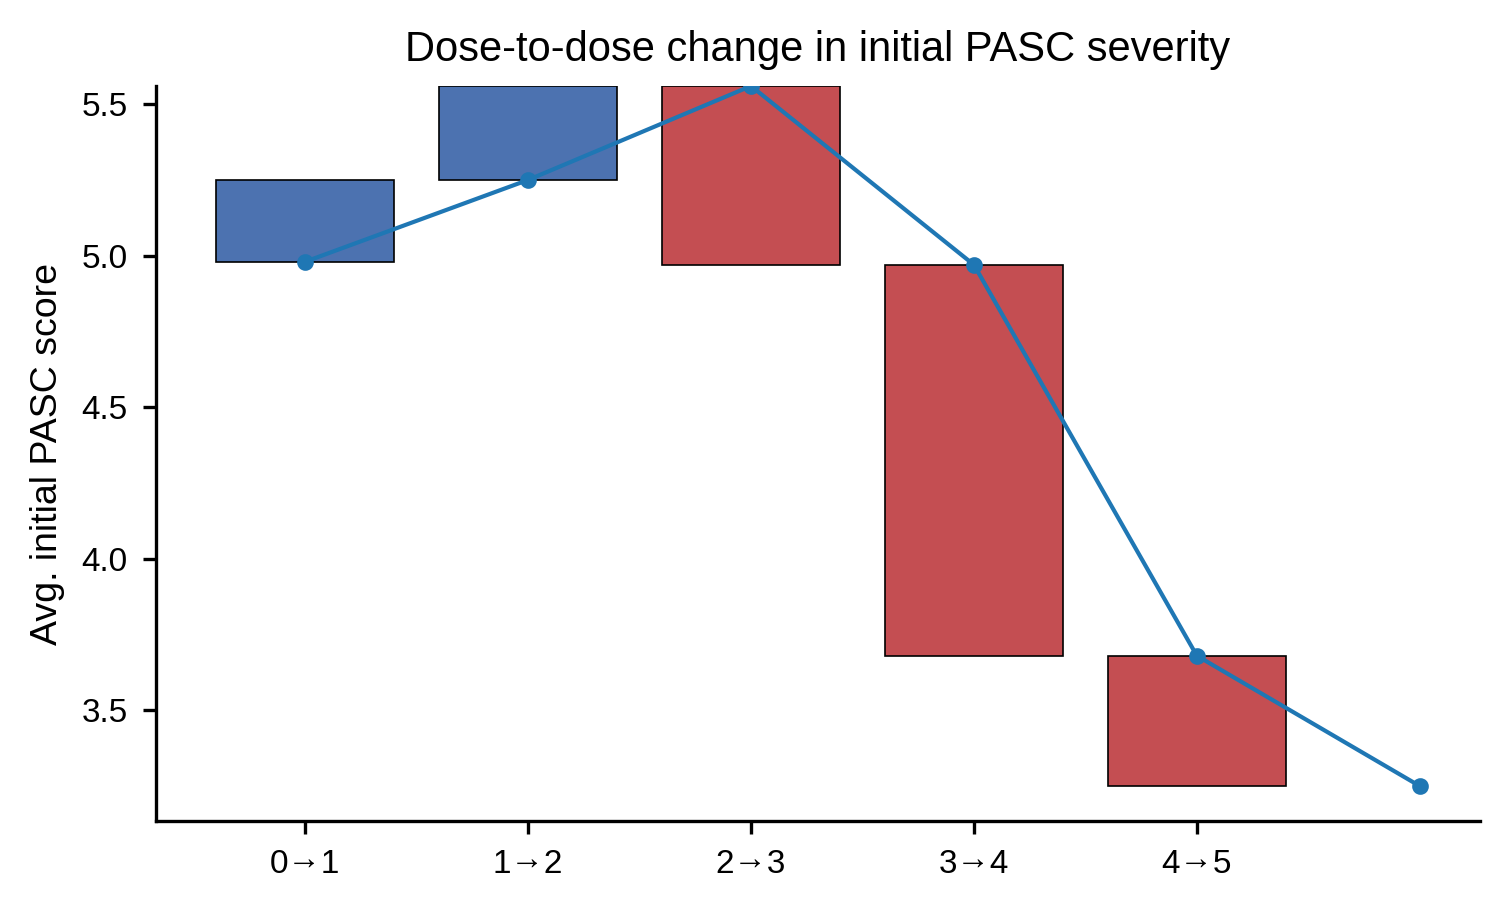

In [50]:
import numpy as np
import matplotlib.pyplot as plt

dose = np.array([0, 1, 2, 3, 4, 5])
mean = np.array([4.98, 5.25, 5.56, 4.97, 3.68, 3.25])

# dose-to-dose delta in score units
delta = np.diff(mean)               # length 5, for steps 0->1, 1->2, ...
step_labels = [f"{dose[i]}→{dose[i+1]}" for i in range(len(dose)-1)]

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

fig, ax = plt.subplots(figsize=(5.0, 3.0), dpi=300)

# Starting value
starts = np.r_[mean[0], mean[0] + np.cumsum(delta)[:-1]]
colors = np.where(delta >= 0, "#4C72B0", "#C44E52")  # blue up, red down

ax.bar(step_labels, delta, bottom=starts, edgecolor="black", linewidth=0.4, color=colors)

# Draw running total line (optional)
running = mean
ax.plot(range(len(dose)), running, linewidth=1.0, marker="o", markersize=3)

ax.set_ylabel("Avg. initial PASC score", fontsize=9)
ax.tick_params(direction="out", length=3.2, width=0.8, labelsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_title("Dose-to-dose change in initial PASC severity", fontsize=10, pad=6)
fig.tight_layout(pad=0.6)
fig.savefig("Fig_Table4_Waterfall_InitialPASC.pdf", bbox_inches="tight")
plt.show()


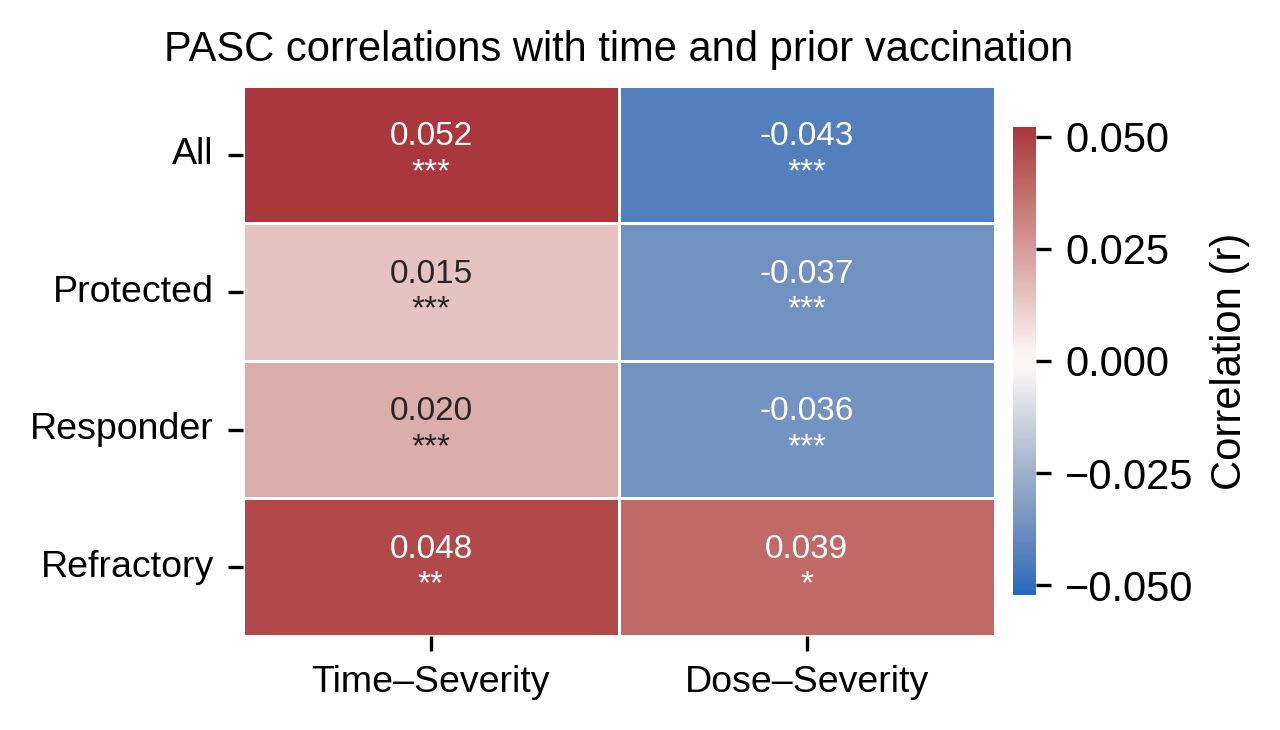

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Data from your Table 4
# -----------------------------
df_corr = pd.DataFrame({
    "Group": ["All", "Protected", "Responder", "Refractory"],
    "Time_r": [0.0521, 0.0145, 0.0201, 0.0475],
    "Time_p": [1.2573e-59, 2.93e-4, 7.5296e-4, 2.4075e-3],
    "Dose_r": [-0.0434, -0.0366, -0.0360, 0.0390],
    "Dose_p": [5.9548e-42, 8.0753e-20, 1.5577e-9, 1.2677e-2],
})

ORDER = ["All", "Protected", "Responder", "Refractory"]
df_corr["Group"] = pd.Categorical(df_corr["Group"], categories=ORDER, ordered=True)
df_corr = df_corr.sort_values("Group")

def stars(p):
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "ns"

# Heatmap numeric matrix (colors)
heat = df_corr.set_index("Group")[["Time_r", "Dose_r"]].rename(
    columns={"Time_r": "Time–Severity", "Dose_r": "Dose–Severity"}
)

# Annotation matrix (text)
annot = pd.DataFrame(index=heat.index, columns=heat.columns, dtype=object)
for _, row in df_corr.iterrows():
    g = row["Group"]
    annot.loc[g, "Time–Severity"] = f"{row['Time_r']:.3f}\n{stars(row['Time_p'])}"
    annot.loc[g, "Dose–Severity"] = f"{row['Dose_r']:.3f}\n{stars(row['Dose_p'])}"

# -----------------------------
# Nature-ish styling
# -----------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

# symmetric color range around 0
vmax = np.nanmax(np.abs(heat.to_numpy()))
vmin = -vmax

fig, ax = plt.subplots(figsize=(4.2, 2.4), dpi=300)

sns.heatmap(
    heat,
    ax=ax,
    cmap="vlag",          # diverging around 0
    vmin=vmin, vmax=vmax, center=0,
    annot=annot, fmt="",
    annot_kws={"fontsize": 8},
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Correlation (r)", "shrink": 0.85, "pad": 0.02},
)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=9, rotation=0)
ax.tick_params(axis="y", labelsize=9, rotation=0)

# Clean spines for Nature style
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("PASC correlations with time and prior vaccination", fontsize=10, pad=6)

fig.tight_layout(pad=0.6)
fig.savefig("Heatmap_Correlations_TimeDose.pdf", bbox_inches="tight")
plt.show()


/tmp/ipykernel_321/1963334386.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.6)


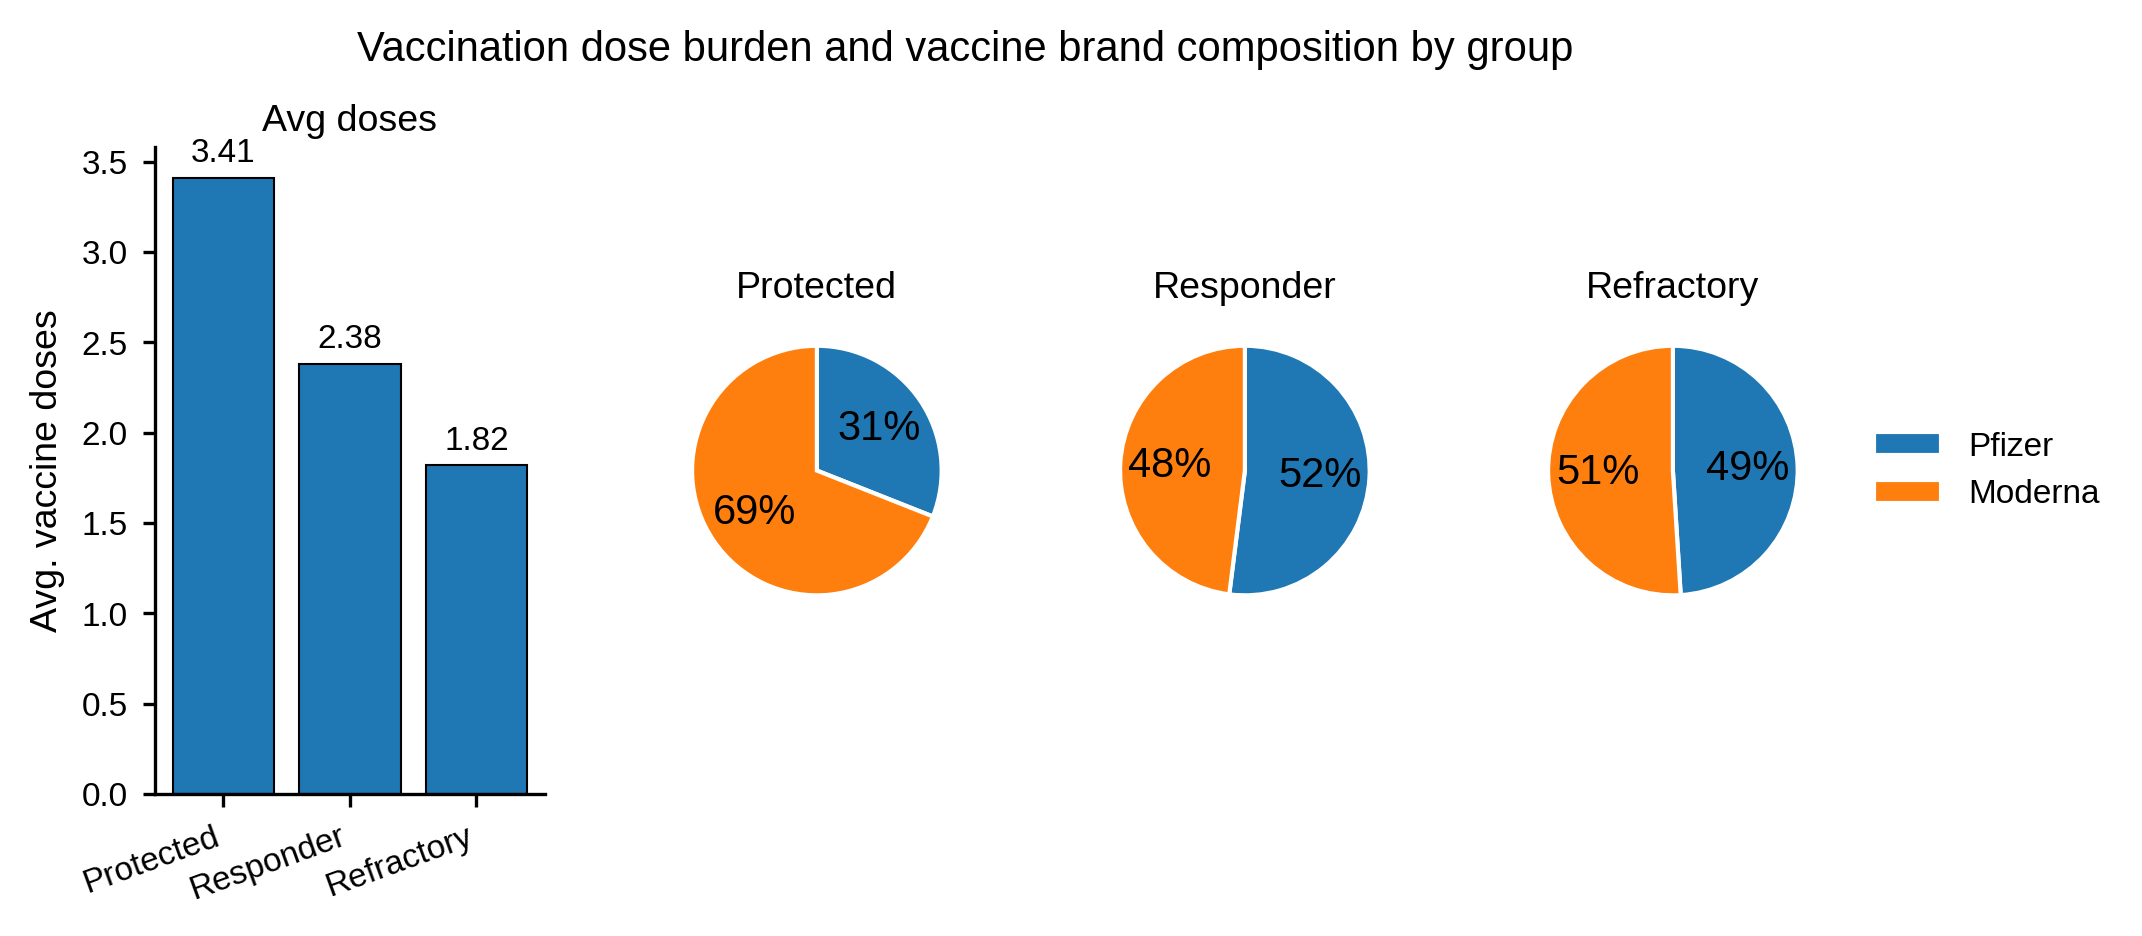

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Data from Table 3 -----
groups = ["Protected", "Responder", "Refractory"]
avg_doses = [3.41, 2.38, 1.82]  # Avg. Vaccine Doses

# Brand (Pfizer/Moderna) as percentages
brand = {
    "Protected":  [31, 69],
    "Responder":  [52, 48],
    "Refractory": [49, 51]
}
brand_labels = ["Pfizer", "Moderna"]

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

fig = plt.figure(figsize=(7.2, 2.8), dpi=300)
gs = fig.add_gridspec(1, 4, width_ratios=[1.25, 1, 1, 1], wspace=0.35)

# ---------------- Panel A: Avg doses (bar) ----------------
ax0 = fig.add_subplot(gs[0, 0])
x = np.arange(len(groups))
ax0.bar(x, avg_doses, edgecolor="black", linewidth=0.5)

ax0.set_xticks(x)
ax0.set_xticklabels(groups, rotation=20, ha="right", fontsize=8)
ax0.set_ylabel("Avg. vaccine doses", fontsize=9)
ax0.set_title("Avg doses", fontsize=9, pad=4)

ax0.tick_params(direction="out", length=3, width=0.8, labelsize=8)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)

# value labels
for xi, v in zip(x, avg_doses):
    ax0.text(xi, v + 0.05, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

# ---------------- Panel B–D: Brand pies ----------------
pie_axes = []
for i, g in enumerate(groups, start=1):
    ax = fig.add_subplot(gs[0, i])
    vals = brand[g]

    ax.pie(
        vals,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor="white", linewidth=1.0),
        autopct=lambda p: f"{p:.0f}%" if p >= 8 else ""  # avoid tiny labels
    )
    ax.set_title(g, fontsize=9, pad=4)
    pie_axes.append(ax)
    
# One shared legend for pies
pie_axes[-1].legend(
    brand_labels,
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=8
)

fig.suptitle("Vaccination dose burden and vaccine brand composition by group", fontsize=10, y=1.02)
fig.tight_layout(pad=0.6)
fig.savefig("Table3_LastTwoRows_BarPlusPies.pdf", bbox_inches="tight")
plt.show()


In [54]:
import numpy as np
import pandas as pd

ID_COL = "id"
DATE_COL = "date"
SCORE_COL = "name"  # <-- your PASC score column
GROUP_COL = "group" # you already created this earlier

RECOVERY_THRESHOLD = 0          # change if needed
REQUIRE_SUSTAINED = False       # set True if you want sustained recovery
SUSTAINED_K = 2                 # how many consecutive visits at/below threshold

df = pasc_df.copy()
conditions = [
    df['id'].isin(protected_ids),
    df['id'].isin(responder_ids),
    df['id'].isin(refractory_ids)
]
choices = ['Protected', 'Responder', 'Refractory']

# Create the new 'group' column
# The 'default' parameter is for any ID that doesn't match the lists
df['group'] = np.select(conditions, choices, default='Unknown')

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.dropna(subset=[ID_COL, DATE_COL, SCORE_COL, GROUP_COL]).sort_values([ID_COL, DATE_COL])

def first_recovery_time(d):
    """Return (time_to_event_days, event_observed)."""
    d = d.sort_values(DATE_COL).copy()
    t0 = d[DATE_COL].iloc[0]
    d["t_days"] = (d[DATE_COL] - t0).dt.days
    recovered = d[SCORE_COL].to_numpy() <= RECOVERY_THRESHOLD

    if not REQUIRE_SUSTAINED:
        idx = np.where(recovered)[0]
        if len(idx) == 0:
            return d["t_days"].iloc[-1], 0  # censored at last follow-up
        return int(d["t_days"].iloc[idx[0]]), 1

    # sustained recovery: first index where K consecutive recovered visits occur
    if len(recovered) < SUSTAINED_K:
        return d["t_days"].iloc[-1], 0
    run = np.convolve(recovered.astype(int), np.ones(SUSTAINED_K, dtype=int), mode="valid")
    idx = np.where(run == SUSTAINED_K)[0]
    if len(idx) == 0:
        return d["t_days"].iloc[-1], 0
    return int(d["t_days"].iloc[idx[0]]), 1

rows = []
for pid, d in df.groupby(ID_COL):
    t, e = first_recovery_time(d)
    rows.append({
        ID_COL: pid,
        GROUP_COL: d[GROUP_COL].iloc[0],
        "time_days": t,
        "event": e,
        "t0": d[DATE_COL].iloc[0],
        "t_last": d[DATE_COL].iloc[-1],
        "n_visits": len(d)
    })

df_tte = pd.DataFrame(rows)
df_tte.head()


,id,group,time_days,event,t0,t_last,n_visits
0,RA11,Responder,798,0,2022-01-02,2024-03-10,10
1,RA110,Protected,300,1,2023-01-18,2024-10-06,8
2,RA1100,Protected,232,1,2022-01-01,2024-01-16,8
3,RA11000,Protected,0,1,2022-01-04,2023-12-26,10
4,RA110000,Protected,650,1,2022-01-01,2024-01-10,8


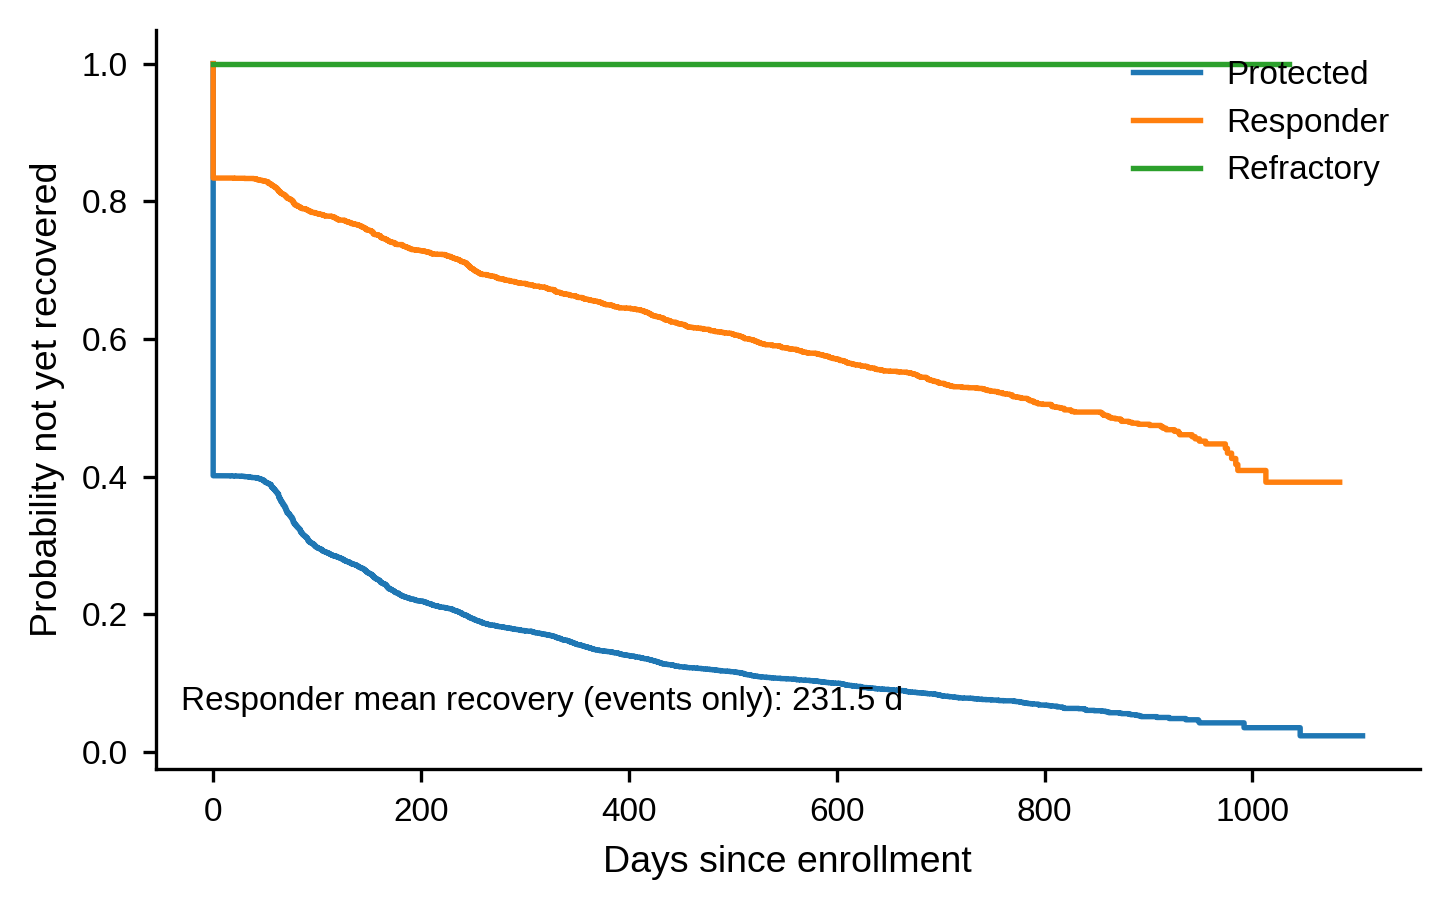

In [55]:
import matplotlib.pyplot as plt

def km_curve(time, event):
    """Return stepwise (t, S(t)) for Kaplan–Meier survival estimate."""
    time = np.asarray(time)
    event = np.asarray(event).astype(int)

    # event times only
    uniq_t = np.sort(np.unique(time[event == 1]))
    S = 1.0
    ts = [0]
    Ss = [1.0]

    for t in uniq_t:
        at_risk = np.sum(time >= t)
        d = np.sum((time == t) & (event == 1))
        if at_risk > 0:
            S *= (1 - d / at_risk)
        ts.extend([t, t])
        Ss.extend([Ss[-1], S])

    # end at max follow-up
    ts.append(time.max())
    Ss.append(Ss[-1])
    return np.array(ts), np.array(Ss)

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8,
})

fig, ax = plt.subplots(figsize=(4.8, 3.0), dpi=300)

for grp in ["Protected", "Responder", "Refractory"]:
    d = df_tte[df_tte[GROUP_COL] == grp]
    if d.empty:
        continue
    t, S = km_curve(d["time_days"], d["event"])
    ax.step(t, S, where="post", linewidth=1.3, label=grp)

    # Mean time to recovery among recovered only (descriptive)
    rec = d[d["event"] == 1]["time_days"]
    if len(rec) > 0 and grp == "Responder":
        ax.text(0.02, 0.08, f"Responder mean recovery (events only): {rec.mean():.1f} d",
                transform=ax.transAxes, fontsize=8)

ax.set_xlabel("Days since enrollment", fontsize=9)
ax.set_ylabel("Probability not yet recovered", fontsize=9)
ax.tick_params(direction="out", length=3.2, width=0.8, labelsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False, fontsize=8, loc="upper right")

fig.tight_layout(pad=0.6)
fig.savefig("KM_TimeToRecovery_byGroup.pdf", bbox_inches="tight")
plt.show()


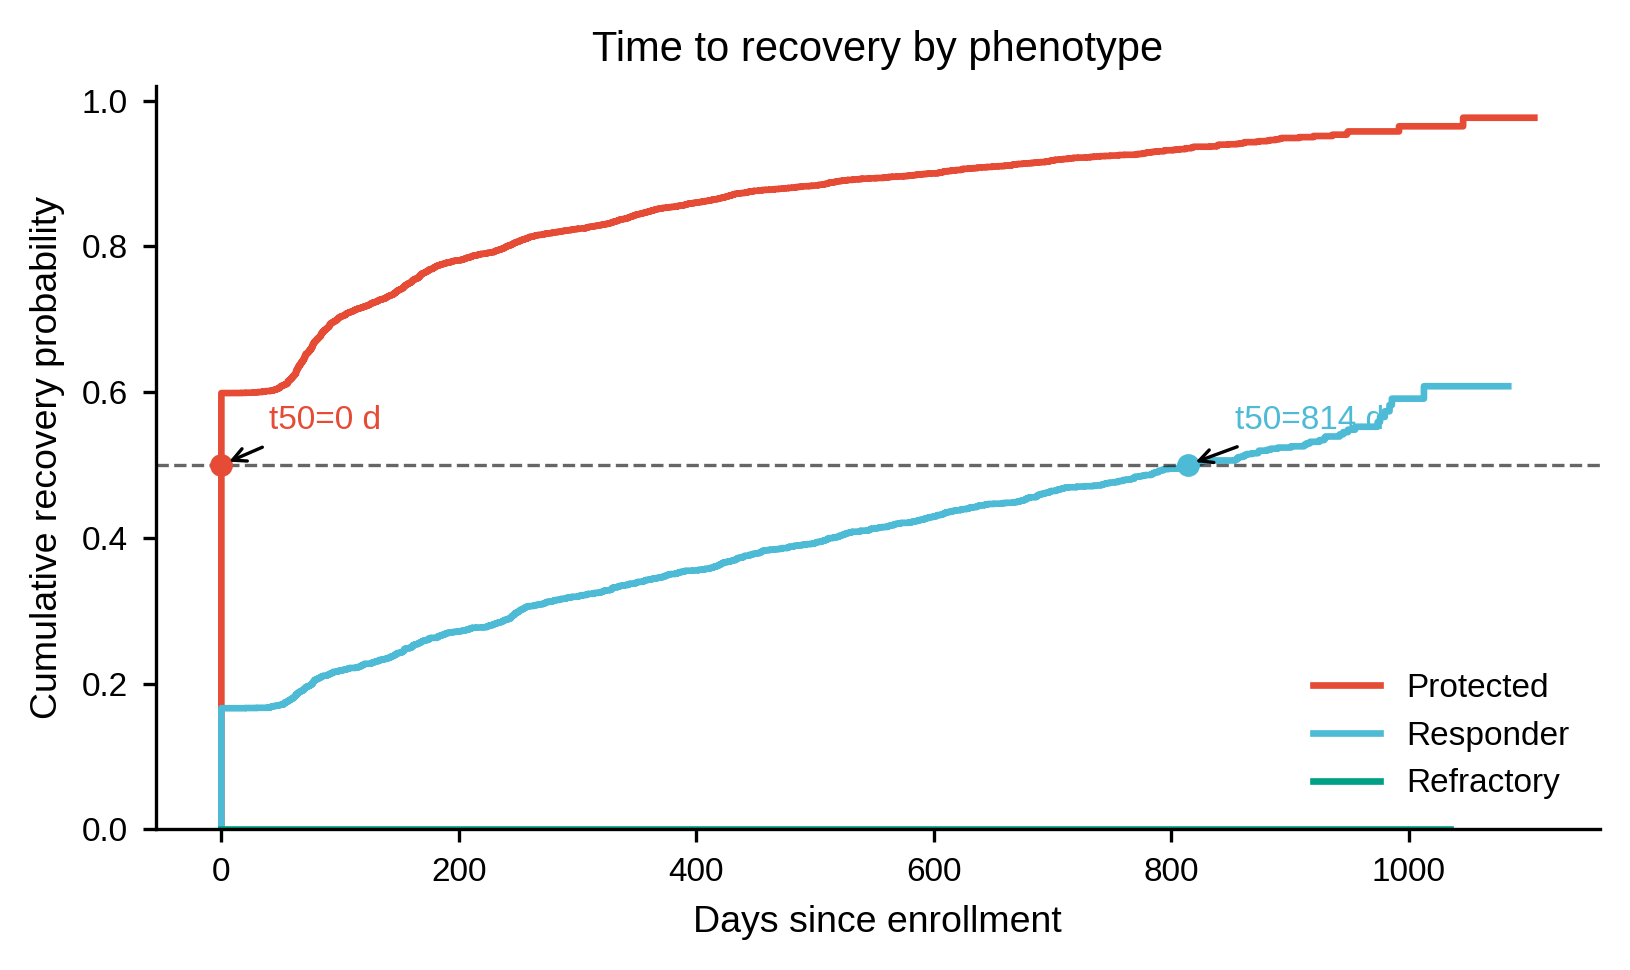

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def km_curve(time, event):
    time = np.asarray(time)
    event = np.asarray(event).astype(int)

    uniq_t = np.sort(np.unique(time[event == 1]))
    S = 1.0
    ts = [0]
    Ss = [1.0]

    for t in uniq_t:
        at_risk = np.sum(time >= t)
        d = np.sum((time == t) & (event == 1))
        if at_risk > 0:
            S *= (1 - d / at_risk)
        ts.extend([t, t])
        Ss.extend([Ss[-1], S])

    ts.append(time.max())
    Ss.append(Ss[-1])
    return np.array(ts), np.array(Ss)

def time_to_fraction_recovered(t, S, frac=0.5):
    # recovered = 1 - S, want first time recovered >= frac
    rec = 1 - S
    idx = np.where(rec >= frac)[0]
    if len(idx) == 0:
        return None
    return float(t[idx[0]])

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

fig, ax = plt.subplots(figsize=(5.4, 3.2), dpi=300)

colors = {"Protected":"#E64B35FF", "Responder":"#4DBBD5FF", "Refractory":"#00A087FF"}

for grp in ["Protected", "Responder", "Refractory"]:
    d = df_tte[df_tte["group"] == grp]
    if d.empty:
        continue

    t, S = km_curve(d["time_days"], d["event"])
    F = 1 - S  # probability recovered

    ax.step(t, F, where="post", linewidth=1.6, color=colors[grp], label=grp)

    # annotate time to 50% recovered if it exists
    t50 = time_to_fraction_recovered(t, S, frac=0.5)
    if t50 is not None:
        ax.scatter([t50], [0.5], s=20, color=colors[grp], zorder=3)
        ax.annotate(f"t50={t50:.0f} d", xy=(t50, 0.5), xytext=(t50+40, 0.55),
                    arrowprops=dict(arrowstyle="->", linewidth=0.8),
                    fontsize=8, color=colors[grp])

# reference line at 50% recovered
ax.axhline(0.5, linestyle="--", linewidth=0.8, color="black", alpha=0.6)

ax.set_xlabel("Days since enrollment", fontsize=9)
ax.set_ylabel("Cumulative recovery probability", fontsize=9)
ax.set_ylim(0, 1.02)

ax.tick_params(direction="out", length=3.2, width=0.8, labelsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False, fontsize=8, loc="lower right")

ax.set_title("Time to recovery by phenotype", fontsize=10, pad=6)

fig.tight_layout(pad=0.6)
fig.savefig("KM_CumulativeRecovery_byGroup.pdf", bbox_inches="tight")
plt.show()


/tmp/ipykernel_321/1913165320.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.8)


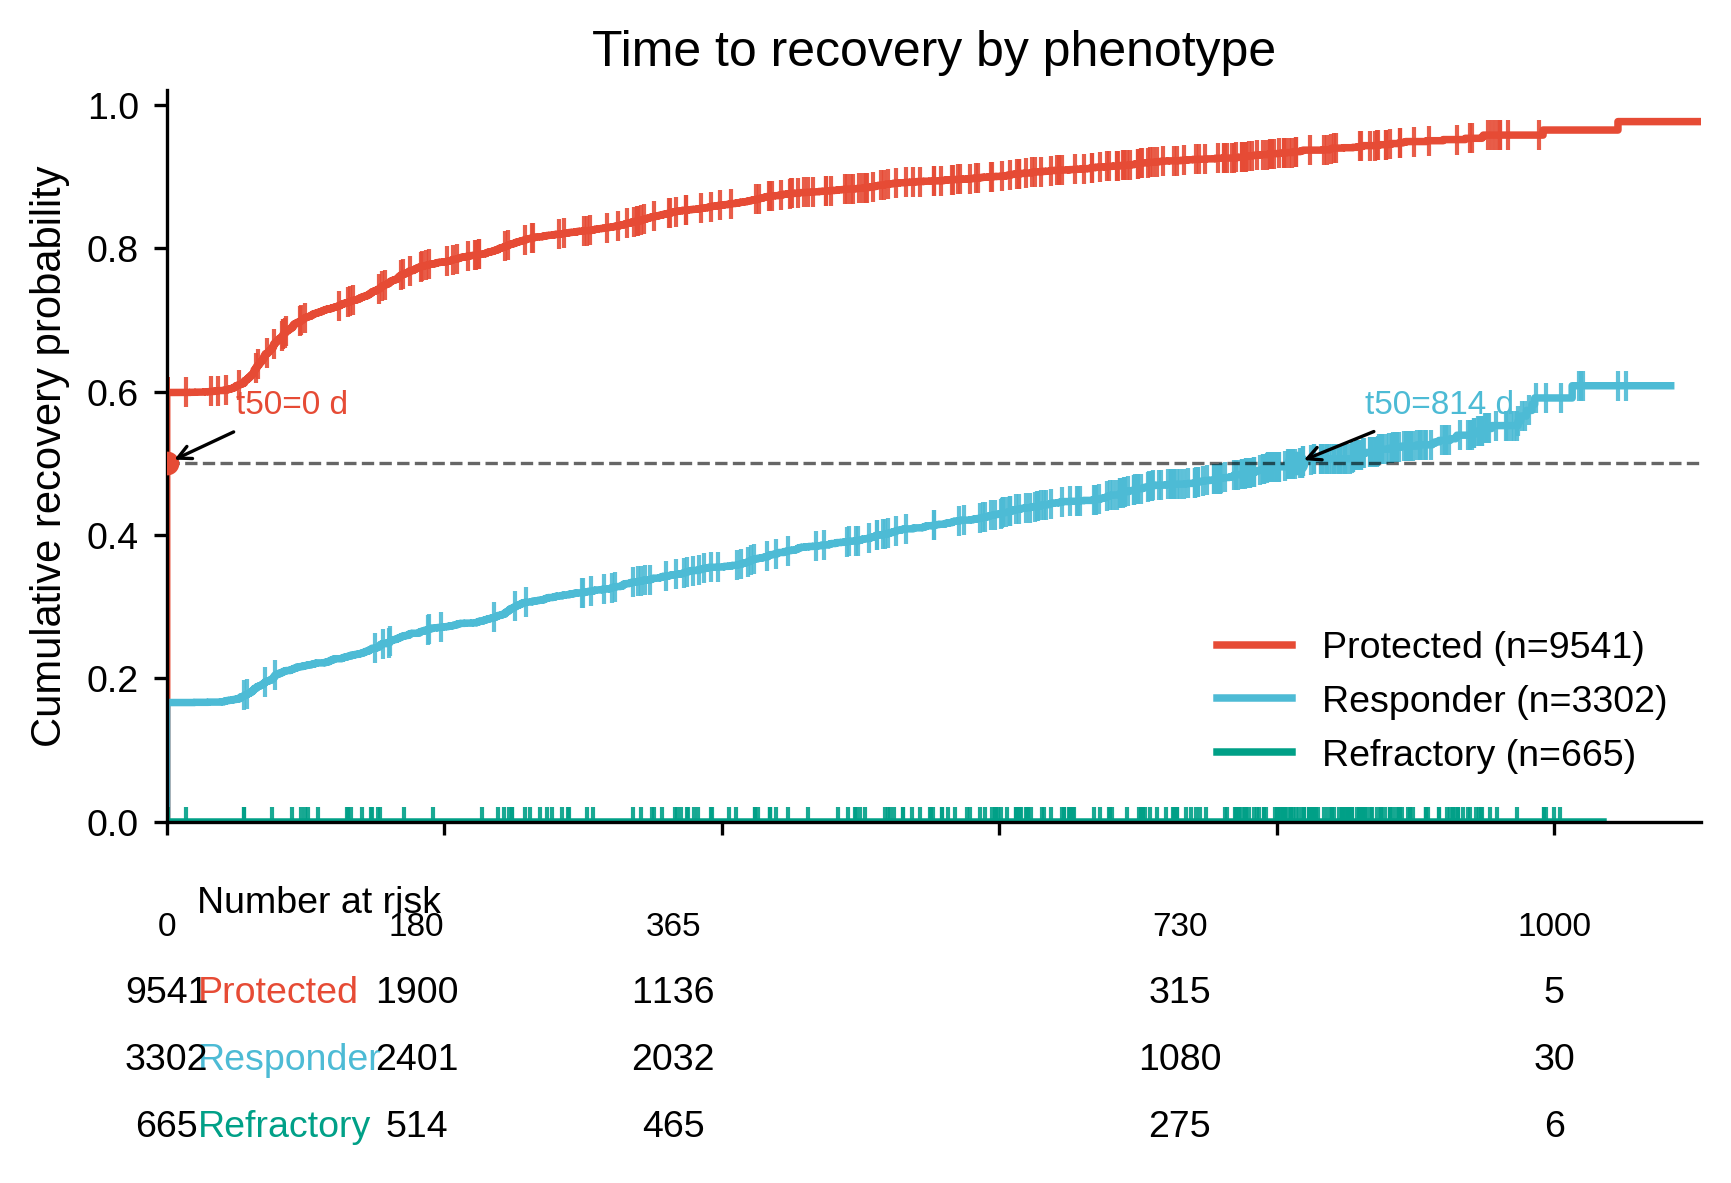

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def km_step(time, event):
    time = np.asarray(time, dtype=float)
    event = np.asarray(event, dtype=int)

    event_times = np.sort(np.unique(time[event == 1]))
    S = 1.0
    ts = [0.0]
    Ss = [1.0]

    for t in event_times:
        at_risk = np.sum(time >= t)
        d = np.sum((time == t) & (event == 1))
        if at_risk > 0:
            S *= (1 - d / at_risk)
        ts.extend([t, t])
        Ss.extend([Ss[-1], S])

    ts.append(time.max())
    Ss.append(Ss[-1])
    return np.array(ts), np.array(Ss)

def survival_at_times(step_t, step_S, qtimes):
    out = []
    for qt in qtimes:
        idx = np.searchsorted(step_t, qt, side="right") - 1
        idx = np.clip(idx, 0, len(step_S)-1)
        out.append(step_S[idx])
    return np.array(out)

def t50_from_steps(step_t, step_S):
    rec = 1 - step_S
    idx = np.where(rec >= 0.5)[0]
    if len(idx) == 0:
        return None
    return float(step_t[idx[0]])

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "Liberation Sans", "Nimbus Sans", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

groups = ["Protected", "Responder", "Refractory"]
colors = {"Protected":"#E64B35FF", "Responder":"#4DBBD5FF", "Refractory":"#00A087FF"}

tmax = float(df_tte["time_days"].max())

# choose clean risk-time columns
risk_times = np.array([0, 180, 365, 730, 1000], dtype=float)
risk_times = risk_times[risk_times <= tmax]

# More vertical space for risk table
fig = plt.figure(figsize=(6.6, 4.6), dpi=300)
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3.4, 1.35], hspace=0.08)

ax = fig.add_subplot(gs[0, 0])
ax_risk = fig.add_subplot(gs[1, 0], sharex=ax)

# ---- Main panel ----
for grp in groups:
    d = df_tte[df_tte["group"] == grp]
    if d.empty:
        continue

    time = d["time_days"].to_numpy(dtype=float)
    event = d["event"].to_numpy(dtype=int)

    step_t, step_S = km_step(time, event)
    step_F = 1 - step_S

    ax.step(step_t, step_F, where="post", linewidth=1.8, color=colors[grp], label=grp)

    # Censor marks: too dense? downsample to reduce clutter
    cens_t = time[event == 0]
    if len(cens_t) > 0:
        # downsample censor marks for readability (keep ~300 max per group)
        if len(cens_t) > 300:
            cens_t = np.sort(np.random.default_rng(0).choice(cens_t, size=300, replace=False))
        S_at_cens = survival_at_times(step_t, step_S, cens_t)
        F_at_cens = 1 - S_at_cens
        ax.plot(cens_t, F_at_cens, linestyle="None", marker="|",
                markersize=7, markeredgewidth=1.0, color=colors[grp], alpha=0.9)

    t50 = t50_from_steps(step_t, step_S)
    if t50 is not None:
        ax.scatter([t50], [0.5], s=22, color=colors[grp], zorder=3)
        ax.annotate(f"t50={t50:.0f} d",
                    xy=(t50, 0.5),
                    xytext=(t50 + 50, 0.57),
                    arrowprops=dict(arrowstyle="->", linewidth=0.8),
                    fontsize=8, color=colors[grp])

ax.axhline(0.5, linestyle="--", linewidth=0.8, color="black", alpha=0.6)
ax.set_ylabel("Cumulative recovery probability", fontsize=10)
ax.set_ylim(0, 1.02)
ax.set_title("Time to recovery by phenotype", fontsize=12, pad=6)

ax.tick_params(direction="out", length=3.2, width=0.8, labelsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend with n, placed higher to avoid overlaps
handles, _ = ax.get_legend_handles_labels()
labels = [f"{g} (n={int((df_tte['group']==g).sum())})" for g in groups]
ax.legend(handles, labels, frameon=False, fontsize=9, loc="lower right", bbox_to_anchor=(1.0, 0.02))

# hide top x tick labels (shared x)
plt.setp(ax.get_xticklabels(), visible=False)

# ---- Risk table panel ----
ax_risk.set_ylim(0, 1)
ax_risk.axis("off")

# Put "Number at risk" in axis coords so it won't collide with data columns
ax_risk.text(0.02, 0.92, "Number at risk", transform=ax_risk.transAxes,
             fontsize=9, ha="left", va="top")

# Print column headers at risk_times (data coords)
for rt in risk_times:
    ax_risk.text(rt, 0.78, f"{int(rt)}", fontsize=8, ha="center", va="center")

# Row positions (axis coords for y, to guarantee spacing)
row_y = {"Protected": 0.55, "Responder": 0.32, "Refractory": 0.09}

# Left group labels in axis coords (fixed column), not data coords
for g in groups:
    ax_risk.text(0.02, row_y[g], g, transform=ax_risk.transAxes,
                 fontsize=9, ha="left", va="center", color=colors[g])

# Risk numbers at each time (data coords)
for g in groups:
    d = df_tte[df_tte["group"] == g]
    time = d["time_days"].to_numpy(dtype=float)
    at_risk = [int(np.sum(time >= rt)) for rt in risk_times]
    for rt, ar in zip(risk_times, at_risk):
        ax_risk.text(rt, row_y[g], str(ar), fontsize=9, ha="center", va="center")

ax_risk.set_xlim(0, tmax)
ax_risk.set_xlabel("Days since enrollment", fontsize=10)

fig.tight_layout(pad=0.8)
fig.savefig("KM_Recovery_withRiskTable_clean.pdf", bbox_inches="tight")
plt.show()
